# Building a Student Intervention System

## Introduction

This notebook presents a comprehensive machine learning pipeline for predicting whether students will pass their final exams. The goal is to develop a student intervention system that can identify students who may need additional support to succeed academically.

The analysis uses the UCI Student Performance dataset, which contains information about secondary education students in Portugal, including demographic data, social factors, and academic performance metrics.

The project follows a standard machine learning workflow:
1. Data Exploration and Visualization
2. Data Cleaning and Preprocessing
3. Feature Engineering and Selection
4. Model Development and Training
5. Model Evaluation and Comparison
6. Results Interpretation and Insights

Let's begin by importing the necessary libraries and loading the dataset.

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Set visualization style
sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')

# Display all columns
pd.set_option('display.max_columns', None)

# For reproducibility
np.random.seed(42)

Check end of notebook for the **Environment Setup**

In [88]:
# Load the dataset
data = pd.read_csv('student-data.csv')

# Display the first few rows
print("Dataset shape:", data.shape)
data.head()

Dataset shape: (395, 31)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,no
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,no
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,yes
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,yes
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,yes


In [89]:
# First, let's first revert some of the categorical data back to a categorical format, as to help with interpretation
categorical_dicts = {
    "edu": {
        0: "none",
        1: "primary education",
        2: "5th to 9th grade",
        3: "secondary education",
        4: "higher education"
    },
    "travel": {
        1: "<15 min",
        2: "15 to 30 min",
        3: "30 min to 1 hour",
        4: ">1 hour"
    },
    "study": {
        1: "<2 hours",
        2: "2 to 5 hours",
        3: "5 to 10 hours",
        4: ">10 hours"
    },
    "famrel": {
        1: "very bad",
        2: "bad",
        3: "ok",
        4: "good",
        5: "excellent"
    },
    "health": {
        1: "very bad",
        2: "bad",
        3: "ok",
        4: "good",
        5: "very good"
    },
    "rest": {
        1: "very low",
        2: "low",
        3: "ok",
        4: "high",
        5: "very high"
    }
}

data["Medu"] = data["Medu"].map(categorical_dicts["edu"])
data["Fedu"] = data["Fedu"].map(categorical_dicts["edu"])
data["traveltime"] = data["traveltime"].map(categorical_dicts["travel"])
data["studytime"] = data["studytime"].map(categorical_dicts["study"])
data["famrel"] = data["famrel"].map(categorical_dicts["famrel"])
data["freetime"] = data["freetime"].map(categorical_dicts["rest"])
data["goout"] = data["goout"].map(categorical_dicts["rest"])
data["Dalc"] = data["Dalc"].map(categorical_dicts["rest"])
data["Walc"] = data["Walc"].map(categorical_dicts["rest"])
data["health"] = data["health"].map(categorical_dicts["health"])
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,GP,F,18,U,GT3,A,higher education,higher education,at_home,teacher,course,mother,15 to 30 min,2 to 5 hours,0,yes,no,no,no,yes,yes,no,no,good,ok,high,very low,very low,ok,6,no
1,GP,F,17,U,GT3,T,primary education,primary education,at_home,other,course,father,<15 min,2 to 5 hours,0,no,yes,no,no,no,yes,yes,no,excellent,ok,ok,very low,very low,ok,4,no
2,GP,F,15,U,LE3,T,primary education,primary education,at_home,other,other,mother,<15 min,2 to 5 hours,3,yes,no,yes,no,yes,yes,yes,no,good,ok,low,low,ok,ok,10,yes
3,GP,F,15,U,GT3,T,higher education,5th to 9th grade,health,services,home,mother,<15 min,5 to 10 hours,0,no,yes,yes,yes,yes,yes,yes,yes,ok,low,low,very low,very low,very good,2,yes
4,GP,F,16,U,GT3,T,secondary education,secondary education,other,other,home,father,<15 min,2 to 5 hours,0,no,yes,yes,no,yes,yes,no,no,good,ok,low,very low,low,very good,4,yes


In [90]:
# Check data types and basic statistics
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    object
 7   Fedu        395 non-null    object
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    object
 13  studytime   395 non-null    object
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [91]:
# Summary statistics for numerical features
data.describe()

,age,failures,absences
count,395.000000,395.000000,395.000000
mean,16.696203,0.334177,5.708861
std,1.276043,0.743651,8.003096
min,15.000000,0.000000,0.000000
25%,16.000000,0.000000,0.000000
50%,17.000000,0.000000,4.000000
75%,18.000000,0.000000,8.000000
max,22.000000,3.000000,75.000000


In [92]:
# Summary statistics for categorical features
data.describe(include=['object'])

,school,sex,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,passed
count,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395
unique,2,2,2,2,2,5,5,5,5,4,3,4,4,2,2,2,2,2,2,2,2,5,5,5,5,5,5,2
top,GP,F,U,GT3,T,higher education,5th to 9th grade,other,other,course,mother,<15 min,2 to 5 hours,no,yes,no,yes,yes,yes,yes,no,good,ok,ok,very low,very low,very good,yes
freq,349,208,307,281,354,131,115,141,217,145,273,257,198,344,242,214,201,314,375,329,263,195,157,130,276,151,146,265


### 1.1 Check for Missing Values

In [93]:
missing_values = data.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0] if missing_values.any() > 0 else "No missing values found.")

Missing values per column:
No missing values found.


### 1.2 Target Variable Analysis

Let's examine the distribution of our target variable 'passed'.

passed
yes    265
no     130
Name: count, dtype: int64
Percentage of passed students: 67.09%
Percentage of failed students: 32.91%


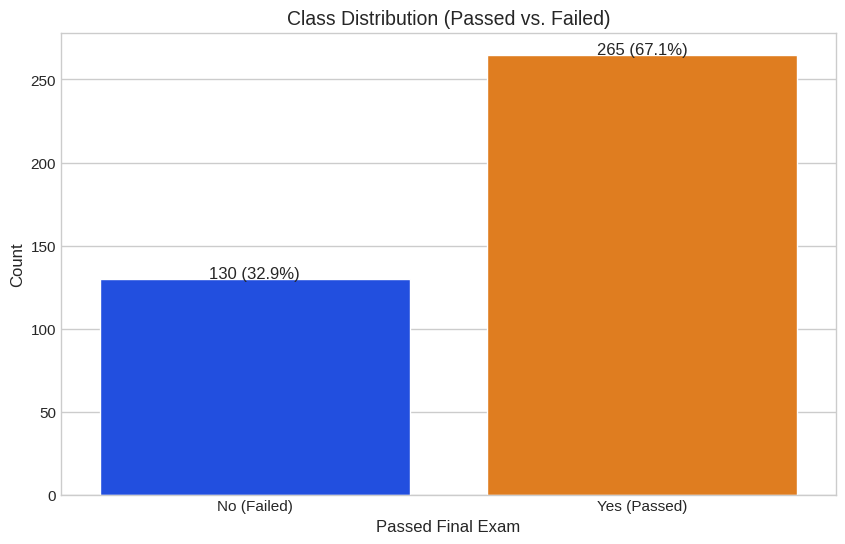

In [94]:
target_counts = data['passed'].value_counts()
print(target_counts)
print(f"Percentage of passed students: {target_counts['yes']/len(data)*100:.2f}%")
print(f"Percentage of failed students: {target_counts['no']/len(data)*100:.2f}%")

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='passed', data=data, hue='passed', palette='bright', legend=False)
plt.title('Class Distribution (Passed vs. Failed)', fontsize=14)
plt.xlabel('Passed Final Exam', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['No (Failed)', 'Yes (Passed)'])
for i, count in enumerate(target_counts[::-1]):
    plt.text(i, count, f"{count} ({count/len(data)*100:.1f}%)", ha='center')
plt.show()

## 2. Exploratory Data Analysis (EDA)

Let's explore the dataset in more detail to understand the relationships between features and the target variable.

### 2.1 Categorical Features Analysis

In [95]:
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('passed')  # Remove target variable
print(f"Categorical features ({len(categorical_features)}):\n{categorical_features}")

Categorical features (27):
['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']


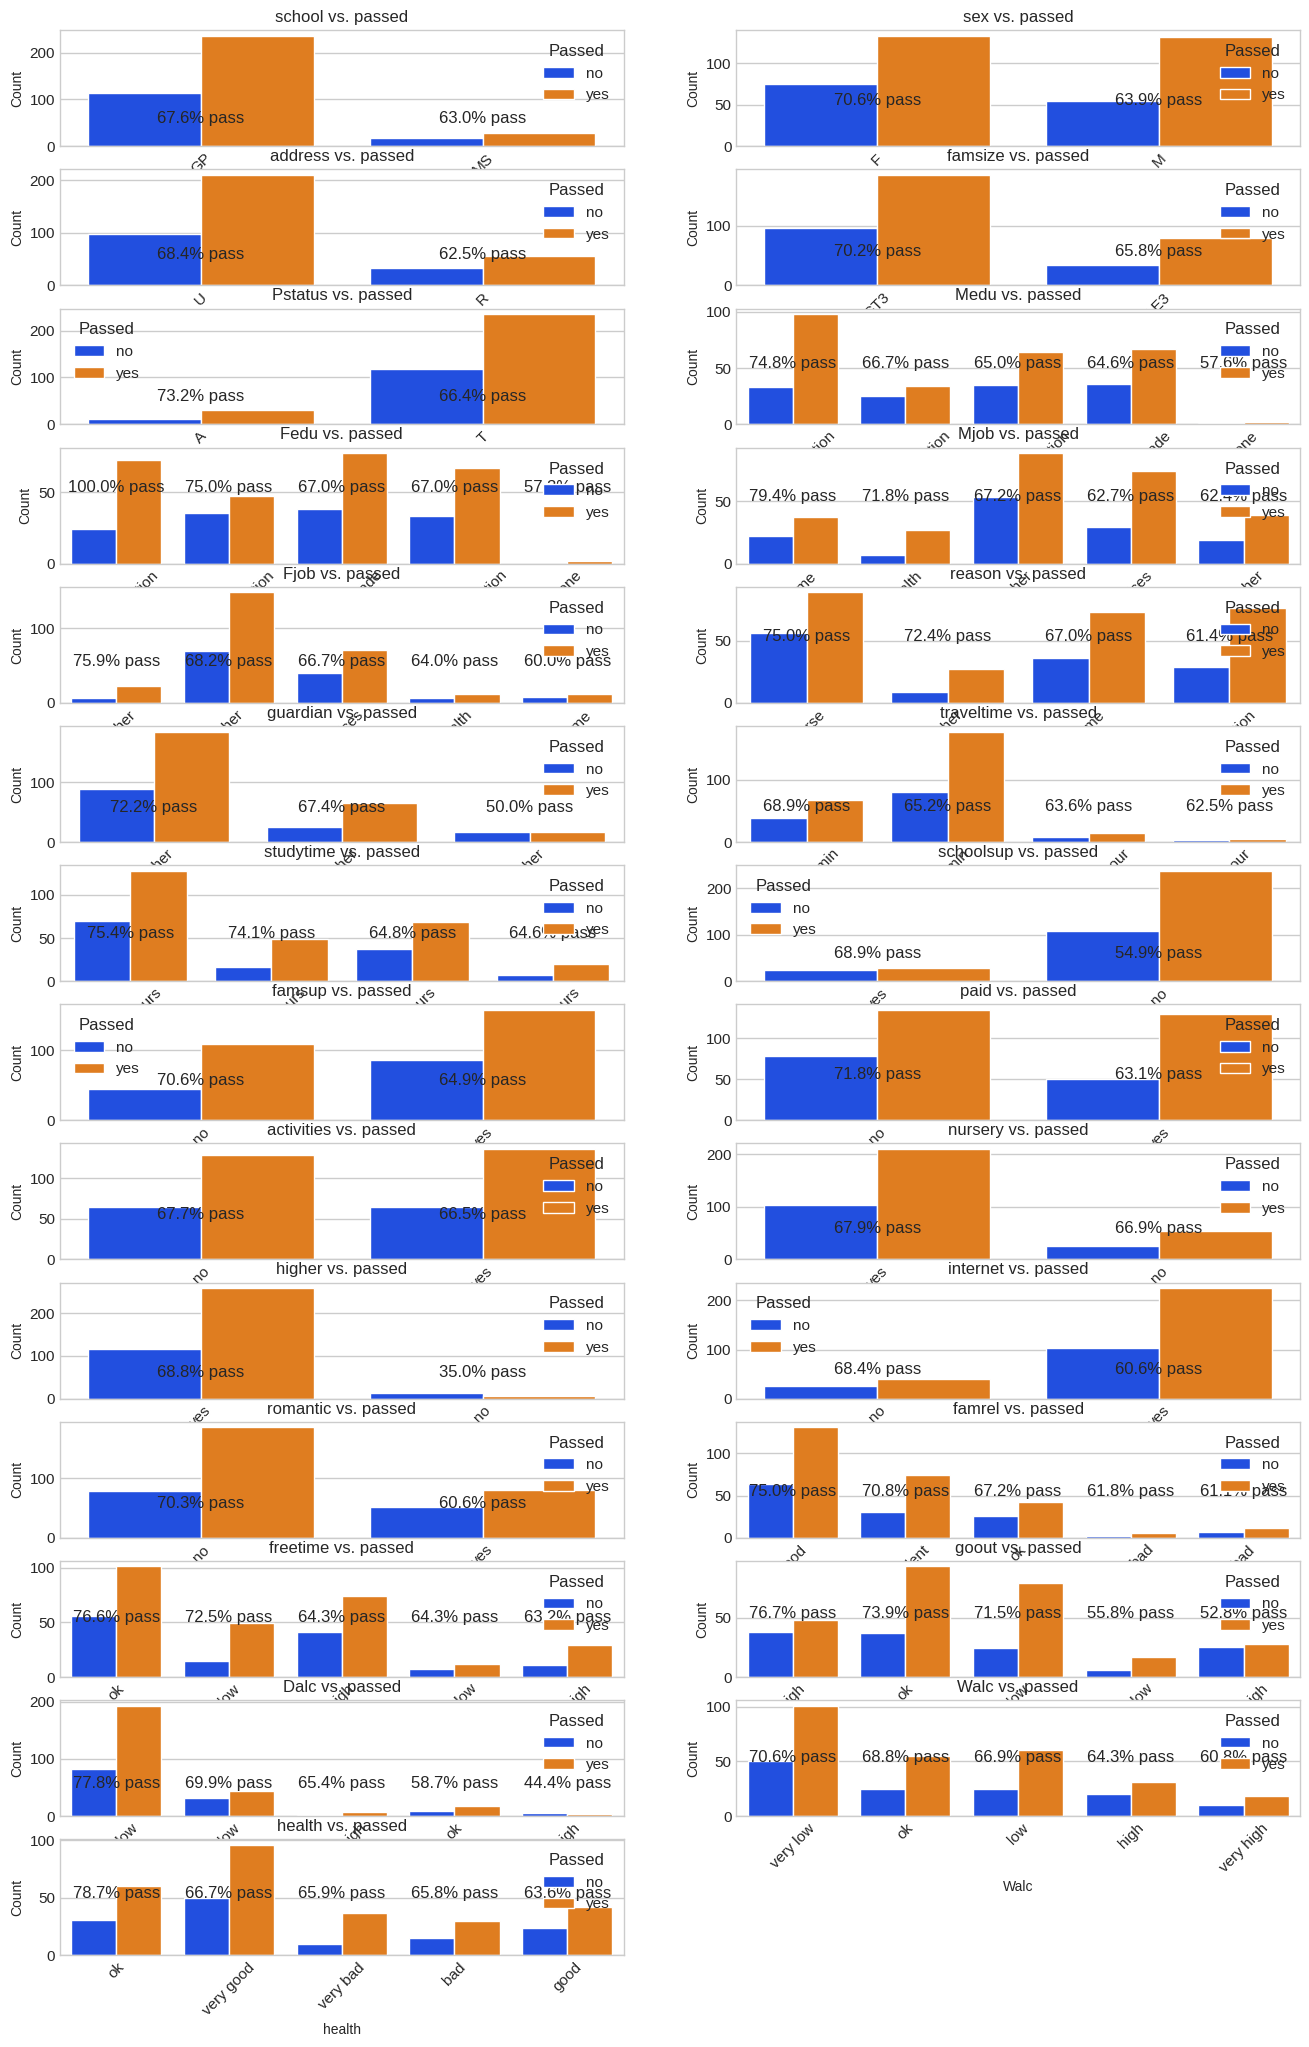

In [96]:
# Function to plot categorical features against the target
def plot_categorical_features(features, data, target, ncols=2, figsize=(16, 25)):
    nrows = int(np.ceil(len(features) / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()
    
    for i, feature in enumerate(features):
        # Calculate percentage of passed students for each category
        feature_data = data.groupby(feature)[target].value_counts(normalize=True).unstack()

        if 'yes' in feature_data.columns:
            feature_data = feature_data['yes'].sort_values(ascending=False)
        
        # Count plot with hue
        sns.countplot(x=feature, hue=target, data=data, ax=axes[i], palette='bright')
        
        # Add percentage labels
        for j, (category, percentage) in enumerate(feature_data.items()):
            count = data[data[feature] == category].shape[0]
            axes[i].text(j, 50, f"{percentage*100:.1f}% pass", ha='center', fontsize=12)
        
        axes[i].set_title(f'{feature} vs. {target}', fontsize=12)
        axes[i].set_xlabel(feature, fontsize=10)
        axes[i].set_ylabel('Count', fontsize=10)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].legend(title='Passed')
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    #plt.tight_layout()
    plt.show()

# Plot categorical features
plot_categorical_features(categorical_features, data, 'passed')

### 2.2 Numerical Features Analysis

In [97]:
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"Numerical features ({len(numerical_features)}):\n{numerical_features}")

Numerical features (3):
['age', 'failures', 'absences']


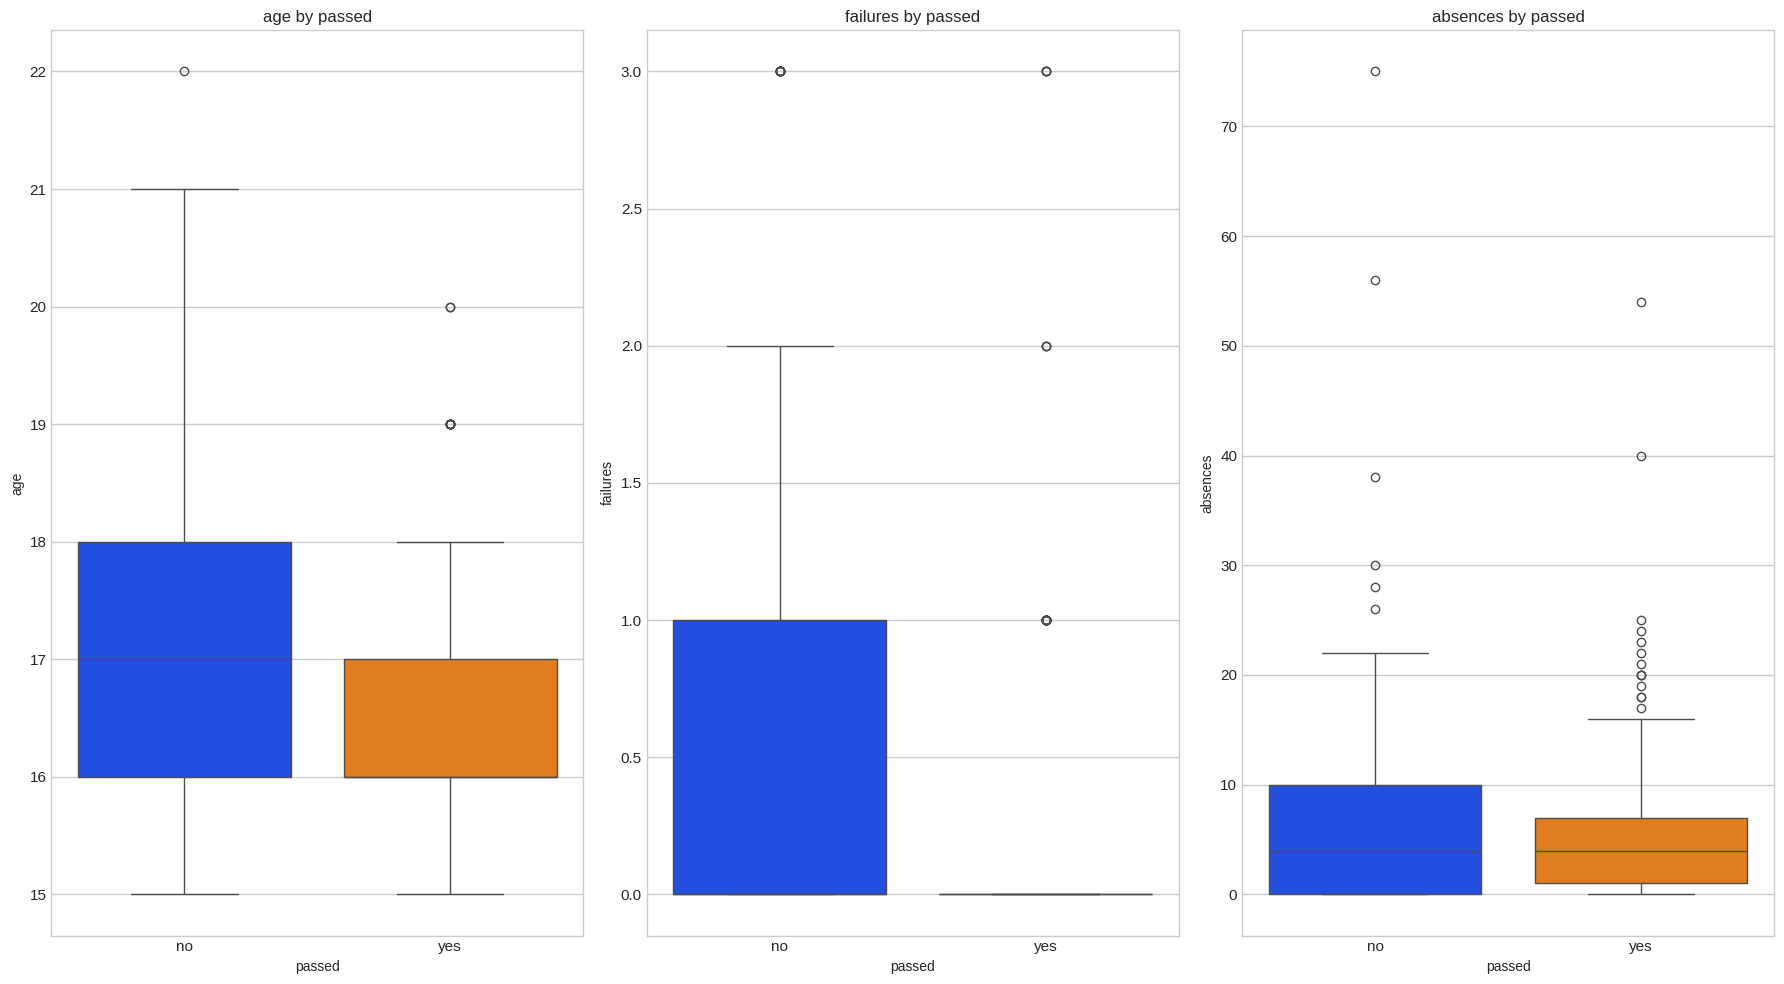

In [98]:
def plot_numerical_features(features, data, target, ncols=3, figsize=(18, 10)):
    nrows = int(np.ceil(len(features) / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()
    
    for i, feature in enumerate(features):
        # Boxplot
        sns.boxplot(x=target, y=feature, data=data, ax=axes[i], hue=target, palette='bright', legend=False)
        axes[i].set_title(f'{feature} by {target}', fontsize=12)
        axes[i].set_xlabel(target, fontsize=10)
        axes[i].set_ylabel(feature, fontsize=10)
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Plot numerical features
plot_numerical_features(numerical_features, data, 'passed')

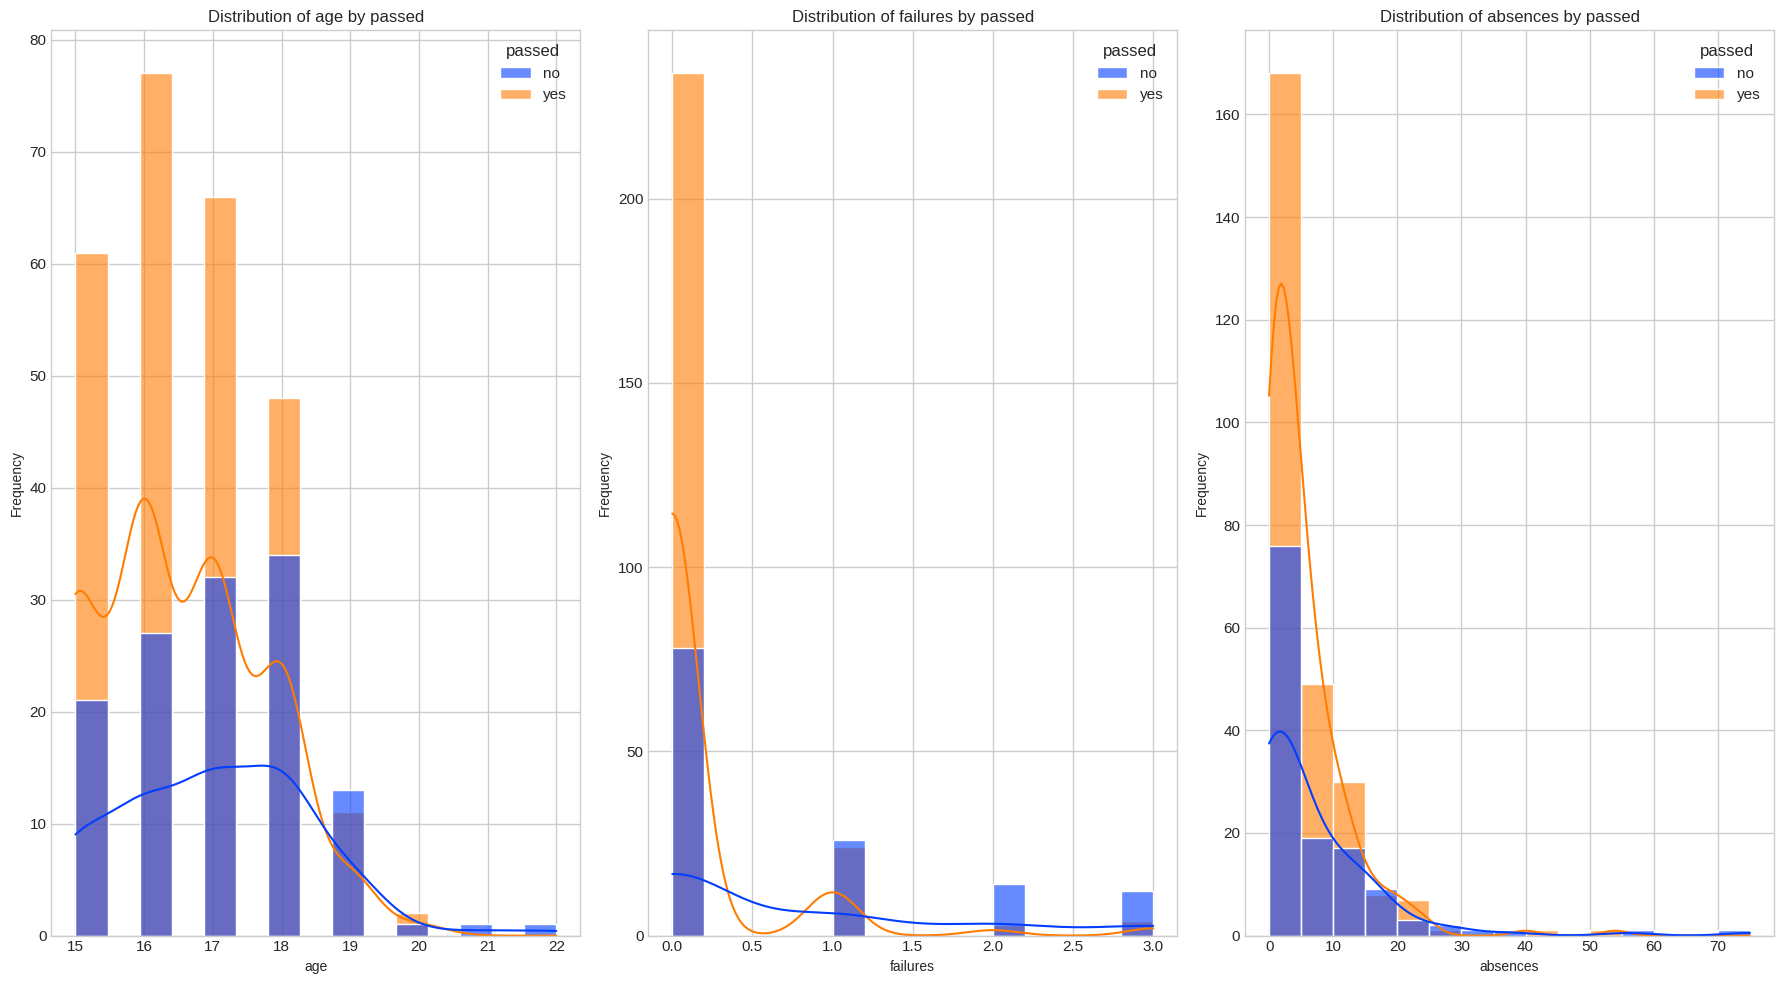

In [99]:
# Histograms for numerical features
def plot_histograms(features, data, target, ncols=3, figsize=(18, 10)):
    nrows = int(np.ceil(len(features) / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()
    
    for i, feature in enumerate(features):
        # Histogram with KDE
        sns.histplot(data=data, x=feature, hue=target, kde=True, ax=axes[i], palette='bright', alpha=0.6, bins=15)
        axes[i].set_title(f'Distribution of {feature} by {target}', fontsize=12)
        axes[i].set_xlabel(feature, fontsize=10)
        axes[i].set_ylabel('Frequency', fontsize=10)
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Plot histograms
plot_histograms(numerical_features, data, 'passed')

### 2.3 Correlation Analysis

To perform this analysis, we used **correlation matrices**, that display the correlation coefficients between numerical features and the target. Essentially, the higher the correlation coefficient, the bigger the connection between them. If its value is lower than zero, they have an inverse relationship.

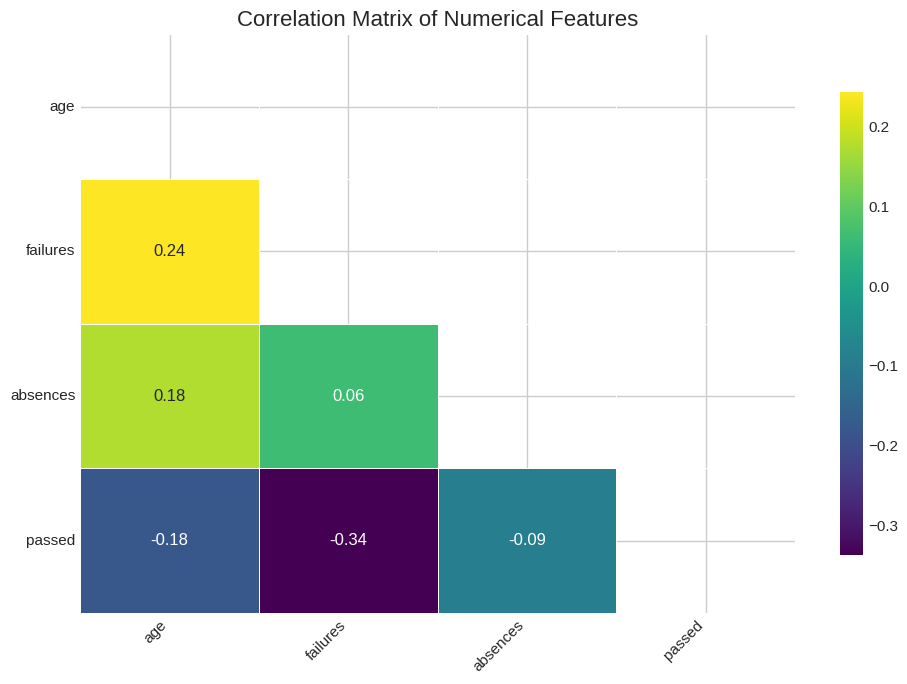

In [100]:
data_corr = data.copy()
data_corr['passed'] = data_corr['passed'].map({'yes': 1, 'no': 0})

# Calculate correlation matrix for numerical features
correlation_matrix = data_corr[numerical_features + ['passed']].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 7))
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='viridis', mask=mask, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [101]:
# Sort features by correlation with target
target_correlations = correlation_matrix['passed'].sort_values(ascending=False)
print("Features sorted by correlation with 'passed':")
print(target_correlations)

Features sorted by correlation with 'passed':
passed      1.000000
absences   -0.092244
age        -0.179645
failures   -0.337731
Name: passed, dtype: float64


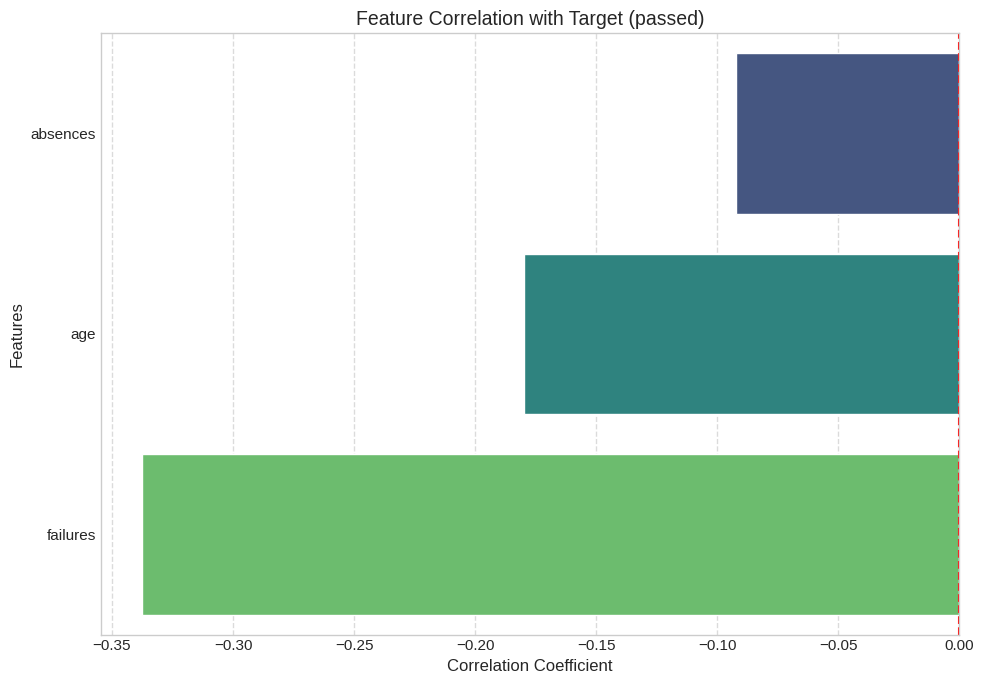

In [102]:
# Visualize top correlations with target
plt.figure(figsize=(10, 7))
target_correlations = target_correlations.drop('passed')
sns.barplot(x=target_correlations.values, y=target_correlations.index, hue=target_correlations.index, palette='viridis', legend=False)
plt.title('Feature Correlation with Target (passed)', fontsize=14)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.axvline(x=0, color='red', linestyle='--')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 2.4 Feature Relationships and Pairplots

A **pairplot** is a matrix of graphs that enables the visualization of the relationship between each pair of variables in a dataset, combining both histograms and scatterplots.

Let's examine relationships between the most important features.

Top correlated features: ['failures', 'age', 'absences']


<Figure size 1200x800 with 0 Axes>

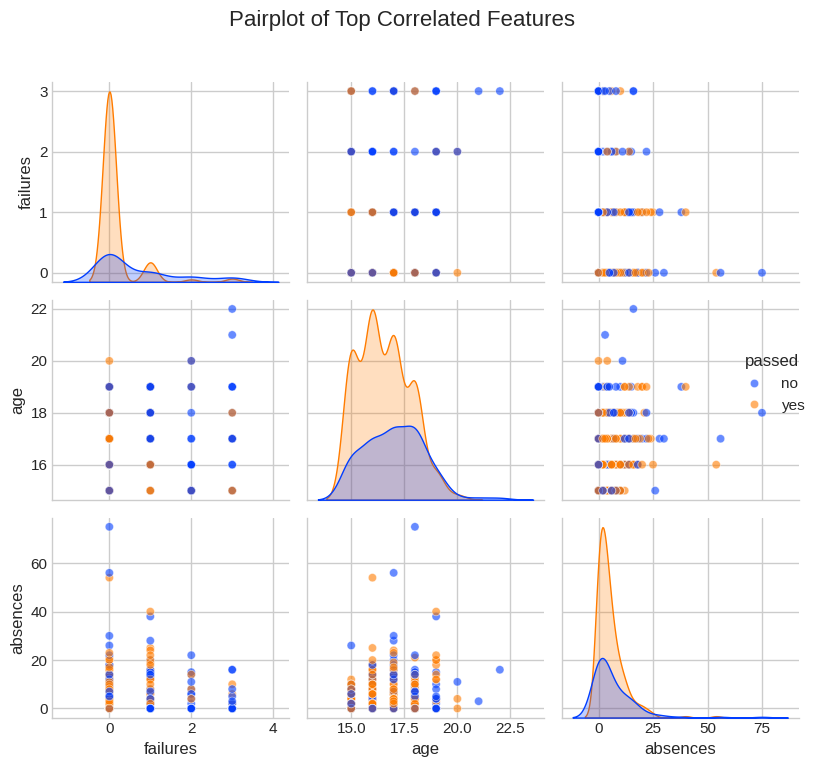

In [103]:
# Select top correlated features for pairplot
top_features = target_correlations.abs().sort_values(ascending=False).head(5).index.tolist()
print(f"Top correlated features: {top_features}")

# Create pairplot
plt.figure(figsize=(12, 8))
sns.pairplot(data=data, vars=top_features, hue='passed', palette='bright', diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Pairplot of Top Correlated Features', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

### 2.5 Outlier Check

Let's check for outliers using the **IQR Method**, since we won't be assuming a normal distribution for every feature.

In [104]:
Q1 = data[numerical_features].quantile(0.25)
Q3 = data[numerical_features].quantile(0.75)
IQR = Q3 - Q1
outliers_mask = (data[numerical_features] < (Q1 - 1.5 * IQR)) | (data[numerical_features] > (Q3 + 1.5 * IQR))
print(outliers_mask.sum())

age          1
failures    83
absences    15
dtype: int64


## 3. Data Preprocessing

Based on our exploratory analysis, let's prepare the data for modeling.

### 3.1 Feature Engineering
We will create new features:
* `has_parent_with_higher_edu` -> At least one parent has a higher education
* `heavy_alcohol_consumption` -> The weekday or weekend alcohol consumption is 'high' or 'very high'
* `studies_enough` -> Studies at least 2 hours

In [105]:
data_processed = data.copy()
data_processed['has_parent_with_higher_edu'] = (
    (data_processed['Medu'] == 'higher education') | 
    (data_processed['Fedu'] == 'higher education')
).astype(int)
data_processed['heavy_alcohol_consumption'] = (
    (data_processed['Dalc'].isin(['high', 'very high'])) | 
    (data_processed['Walc'].isin(['high', 'very high']))
).astype(int)
data_processed['studies_enough'] = (data_processed['studytime'] != '<2 hours').astype(int)

# Display the new features
print("New engineered features:")
data_processed[['has_parent_with_higher_edu', 'heavy_alcohol_consumption', 'studies_enough']].describe()

New engineered features:


,has_parent_with_higher_edu,heavy_alcohol_consumption,studies_enough
count,395.000000,395.000000,395.000000
mean,0.397468,0.205063,0.734177
std,0.489995,0.404260,0.442331
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000
75%,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000


### 3.2 Encoding Categorical Variables

In [106]:
# Identify categorical and numerical features
categorical_features = data_processed.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('passed')  # Remove target variable
numerical_features = data_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Convert binary categorical features to numerical (0/1)
binary_features = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
for feature in binary_features:
    data_processed[feature] = data_processed[feature].map({'yes': 1, 'no': 0})
    if feature in categorical_features:
        categorical_features.remove(feature)
        numerical_features.append(feature)

# Update feature lists
print(f"Remaining categorical features: {categorical_features}")
print(f"Updated numerical features: {numerical_features}")

Remaining categorical features: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']
Updated numerical features: ['age', 'failures', 'absences', 'has_parent_with_higher_edu', 'heavy_alcohol_consumption', 'studies_enough', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


In [107]:
from sklearn.model_selection import train_test_split

# Prepare features and target
X = data_processed.drop('passed', axis=1)
y = data_processed['passed'].map({'yes': 1, 'no': 0})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training set class distribution:\n{y_train.value_counts()}")
print(f"Testing set class distribution:\n{y_test.value_counts()}")

Training set shape: (316, 33)
Testing set shape: (79, 33)
Training set class distribution:
passed
1    212
0    104
Name: count, dtype: int64
Testing set class distribution:
passed
1    53
0    26
Name: count, dtype: int64


### 3.3 Create Preprocessing Pipeline

In [108]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Handle Outliers
def cap_outliers(X):
    """
    Caps features at 1.5*IQR bounds
    
    Args:
        X (ndarray) : Data
    
    Returns:
        X (ndarray) : Data with outliers capped
    """
    Q1 = np.percentile(X, 25, axis=0)
    Q3 = np.percentile(X, 75, axis=0)
    IQR = Q3 - Q1
    return np.clip(X, Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('outlier_capper', FunctionTransformer(cap_outliers, feature_names_out='one-to-one')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit the preprocessor to the training data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed training data shape: {X_train_processed.shape}")
print(f"Processed testing data shape: {X_test_processed.shape}")

Processed training data shape: (316, 89)
Processed testing data shape: (79, 89)


### 3.4 Check for Class Imbalance

Class distribution:
passed
1    265
0    130
Name: count, dtype: int64
Class imbalance ratio: 2.04


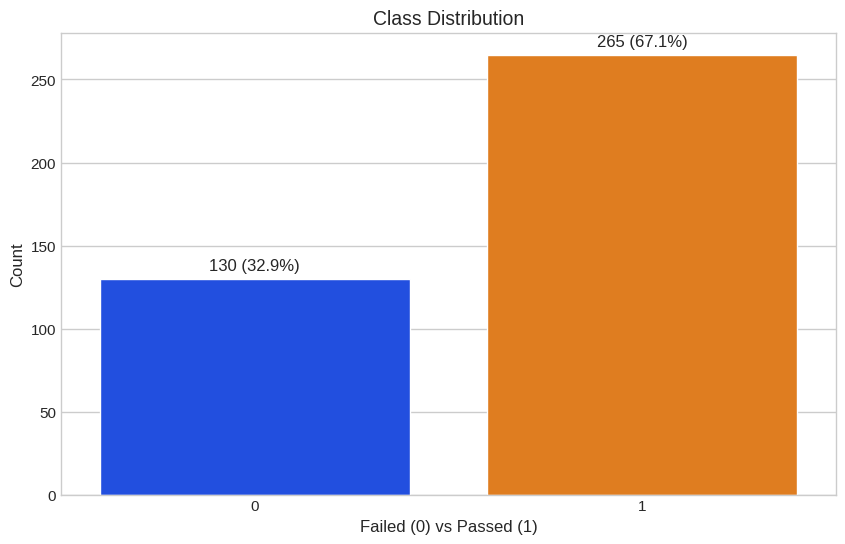

In [109]:
# Check class distribution
class_counts = y.value_counts()
print("Class distribution:")
print(class_counts)
print(f"Class imbalance ratio: {class_counts.max() / class_counts.min():.2f}")

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=y, hue=y, palette='bright', legend=False)
plt.title('Class Distribution', fontsize=14)
plt.xlabel('Failed (0) vs Passed (1)', fontsize=12)
plt.ylabel('Count', fontsize=12)
for i, count in enumerate(class_counts[::-1]):
    plt.text(i, count + 5, f"{count} ({count/len(y)*100:.1f}%)", ha='center')
plt.show()

Observation: **Mild Class Imbalance** (2:1 ratio). This imbalance will need to be addressed since we are building a student intervention system that has the primary goal of correctly identify students who will fail, i.e., a system that catches as many true failures as possible, even if it means some false alarms.

## 4. Model Development and Training

Let's implement and evaluate multiple classification algorithms.

### 4.1 Baseline Models

We evaluated the following models based on their suitability for:

- **Small dataset size** (395 samples)
- **Class imbalance** (2:1 ratio of passed vs failed)
- **Interpretability** (critical for educational interventions)

| **Model**                | **Rationale for Inclusion**                          | **Handling Class Imbalance**                        |
|:----------------------|:--------------------------------------------------:|:-------------------------------------------------|
| Random Forest        | Robust to outliers, handles non-linear relationships | `class_weight` to prioritize failed             |
| Logistic Regression  | Interpretable, efficient for small data          | `class_weight` + L2 regularization              |
| Decision Tree        | For interpretability (visual splits)             | Pruned (`max_depth=3`) + `class_weight`         |
| K-Nearest Neighbors  | Baseline for distance-based patterns             | SMOTE oversampling (no native weighting)        |


Excluded Models:

- **Naive Bayes**: Assumes feature independence (invalid for our dataset).
- **Neural Networks**: Requires larger datasets to avoid overfitting.
- **K-Means**: Unsupervised (not designed for classification).

In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

baseline_models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

**Classification metrics:** these are quantitative measures used to evaluate how well a machine learning model distinguishes between classes.


- **Accuracy** - measures the overall correctness of the model. that is, the ratio of correct predictions to total predictions


- **Precision** - measures how many of the predicted positives are in fact true positives


- **Recall** - measures how many of actually positive instances were correctly identified


- **F1** - balance between precision and recall

In [111]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, overfit=False):
    """
    Trains and evaluates a given model focusing on passed=0 (failed students)
    
    Args:
        model : Model to evaluate
        X_train (ndarray) : X training set
        X_test (ndarray) : X testing set
        y_train (ndarray) : y training set
        y_test (ndarray) : y testing set
    
    Returns:
        Dict of the evaluated metrics
    """
    X_predictor = X_test if not overfit else X_train
    y_predictor = y_test if not overfit else y_train
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions and get probability
    y_pred = model.predict(X_predictor)
    y_prob = model.predict_proba(X_predictor)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_predictor, y_pred)
    failed_precision = precision_score(y_predictor, y_pred, pos_label=0)
    failed_recall = recall_score(y_predictor, y_pred, pos_label=0)
    failed_f1 = f1_score(y_predictor, y_pred, pos_label=0)
    pass_precision = precision_score(y_predictor, y_pred)
    pass_recall = recall_score(y_predictor, y_pred)
    pass_f1 = f1_score(y_predictor, y_pred)
    
    # Calculate ROC AUC if probabilities are available
    roc_auc = roc_auc_score(y_predictor, y_prob) if y_prob is not None else None
    
    return {
        'accuracy': accuracy,
        'failed_precision': failed_precision,
        'failed_recall': failed_recall,
        'failed_f1': failed_f1,
        'pass_precision': pass_precision,
        'pass_recall': pass_recall,
        'pass_f1': pass_f1,
        'roc_auc': roc_auc,
        'predictions': y_pred,
        'probabilities': y_prob
    }

# Evaluate all baseline models
baseline_results = {}
for name, model in baseline_models.items():
    print(f"Training {name}...")
    baseline_results[name] = evaluate_model(model, X_train_processed, X_test_processed, y_train, y_test)
    print(f"""{name}:
    - Accuracy: {baseline_results[name]['accuracy']:.4f}
    - Failed Recall: {baseline_results[name]['failed_recall']:.4f}
    - Failed Precision: {baseline_results[name]['failed_precision']:.4f}
    - Failed F1: {baseline_results[name]['failed_f1']:.4f}
    - Pass Recall: {baseline_results[name]['pass_recall']:.4f}
    - Pass Precision: {baseline_results[name]['pass_precision']:.4f}
    - Pass F1: {baseline_results[name]['pass_f1']:.4f}
    - ROC AUC: {baseline_results[name]['roc_auc']:.4f}
    """)

Training Random Forest...
Random Forest:
    - Accuracy: 0.6962
    - Failed Recall: 0.0769
    - Failed Precision: 1.0000
    - Failed F1: 0.1429
    - Pass Recall: 1.0000
    - Pass Precision: 0.6883
    - Pass F1: 0.8154
    - ROC AUC: 0.6615
    
Training Logistic Regression...
Logistic Regression:
    - Accuracy: 0.5696
    - Failed Recall: 0.2308
    - Failed Precision: 0.3000
    - Failed F1: 0.2609
    - Pass Recall: 0.7358
    - Pass Precision: 0.6610
    - Pass F1: 0.6964
    - ROC AUC: 0.5827
    
Training Decision Tree...
Decision Tree:
    - Accuracy: 0.5316
    - Failed Recall: 0.4231
    - Failed Precision: 0.3333
    - Failed F1: 0.3729
    - Pass Recall: 0.5849
    - Pass Precision: 0.6739
    - Pass F1: 0.6263
    - ROC AUC: 0.5040
    
Training K-Nearest Neighbors...
K-Nearest Neighbors:
    - Accuracy: 0.6582
    - Failed Recall: 0.1154
    - Failed Precision: 0.4286
    - Failed F1: 0.1818
    - Pass Recall: 0.9245
    - Pass Precision: 0.6806
    - Pass F1: 0.7840

In [112]:
# Create a comparison table of model performance
baseline_model_comparison = pd.DataFrame({
    'Model': list(baseline_results.keys()),
    'Accuracy': [baseline_results[model]['accuracy'] for model in baseline_results],
    'Failed Precision': [baseline_results[model]['failed_precision'] for model in baseline_results],
    'Failed Recall': [baseline_results[model]['failed_recall'] for model in baseline_results],
    'Failed F1 Score': [baseline_results[model]['failed_f1'] for model in baseline_results],
    'Pass Precision': [baseline_results[model]['pass_precision'] for model in baseline_results],
    'Pass Recall': [baseline_results[model]['pass_recall'] for model in baseline_results],
    'Pass F1 Score': [baseline_results[model]['pass_f1'] for model in baseline_results],
    'ROC AUC': [baseline_results[model]['roc_auc'] for model in baseline_results]
})

# Sort by Failed F1 score
baseline_model_comparison = baseline_model_comparison.sort_values('Failed F1 Score', ascending=False).reset_index(drop=True)
baseline_model_comparison

,Model,Accuracy,Failed Precision,Failed Recall,Failed F1 Score,Pass Precision,Pass Recall,Pass F1 Score,ROC AUC
0,Decision Tree,0.531646,0.333333,0.423077,0.372881,0.673913,0.584906,0.626263,0.503991
1,Logistic Regression,0.569620,0.300000,0.230769,0.260870,0.661017,0.735849,0.696429,0.582729
2,K-Nearest Neighbors,0.658228,0.428571,0.115385,0.181818,0.680556,0.924528,0.784000,0.576923
3,Random Forest,0.696203,1.000000,0.076923,0.142857,0.688312,1.000000,0.815385,0.661466


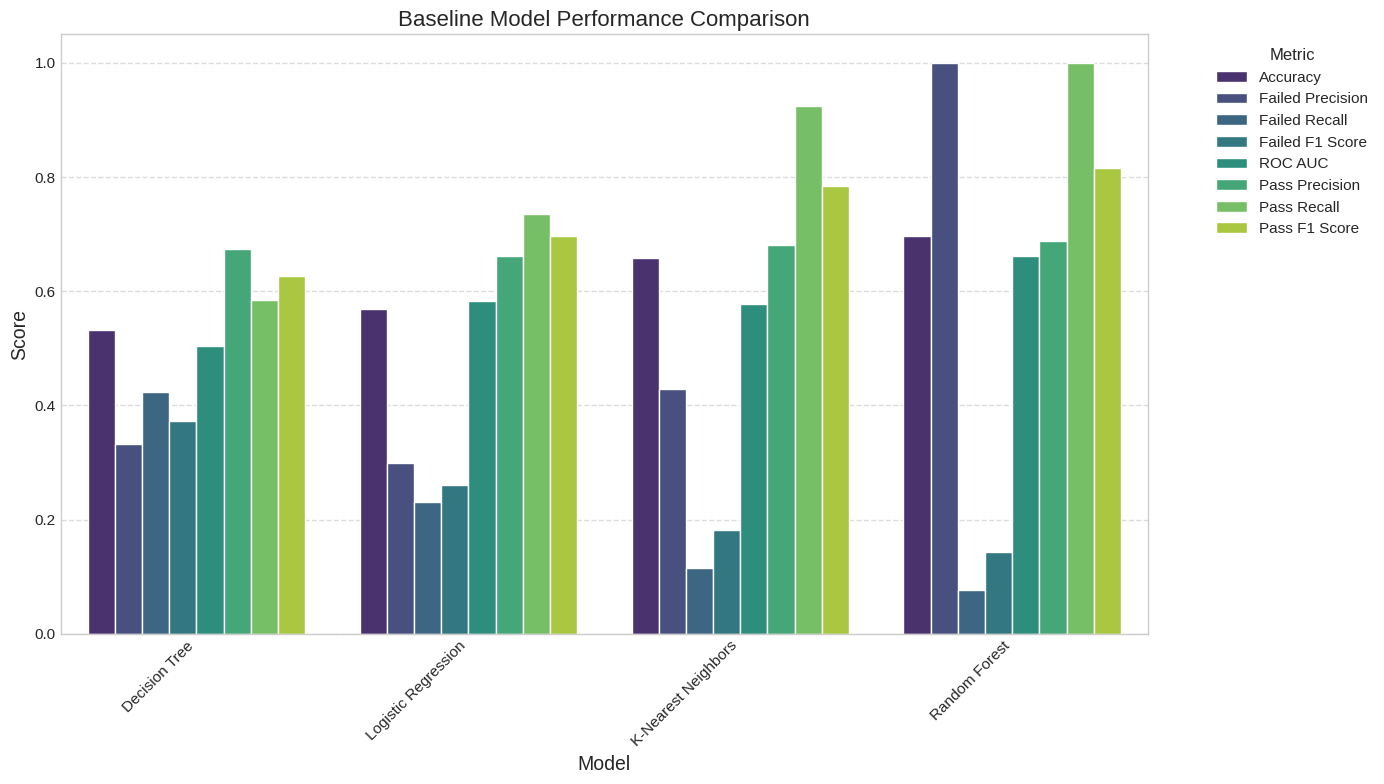

In [113]:
# Visualize model comparison
plt.figure(figsize=(14, 8))
metrics = ['Accuracy', 'Failed Precision', 'Failed Recall', 'Failed F1 Score', 'ROC AUC', 'Pass Precision', 'Pass Recall', 'Pass F1 Score']
baseline_model_comparison_melted = pd.melt(baseline_model_comparison, id_vars=['Model'], value_vars=metrics, var_name='Metric', value_name='Score')

sns.barplot(x='Model', y='Score', hue='Metric', data=baseline_model_comparison_melted, palette='viridis')
plt.title('Baseline Model Performance Comparison', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 4.2 Confusion Matrices

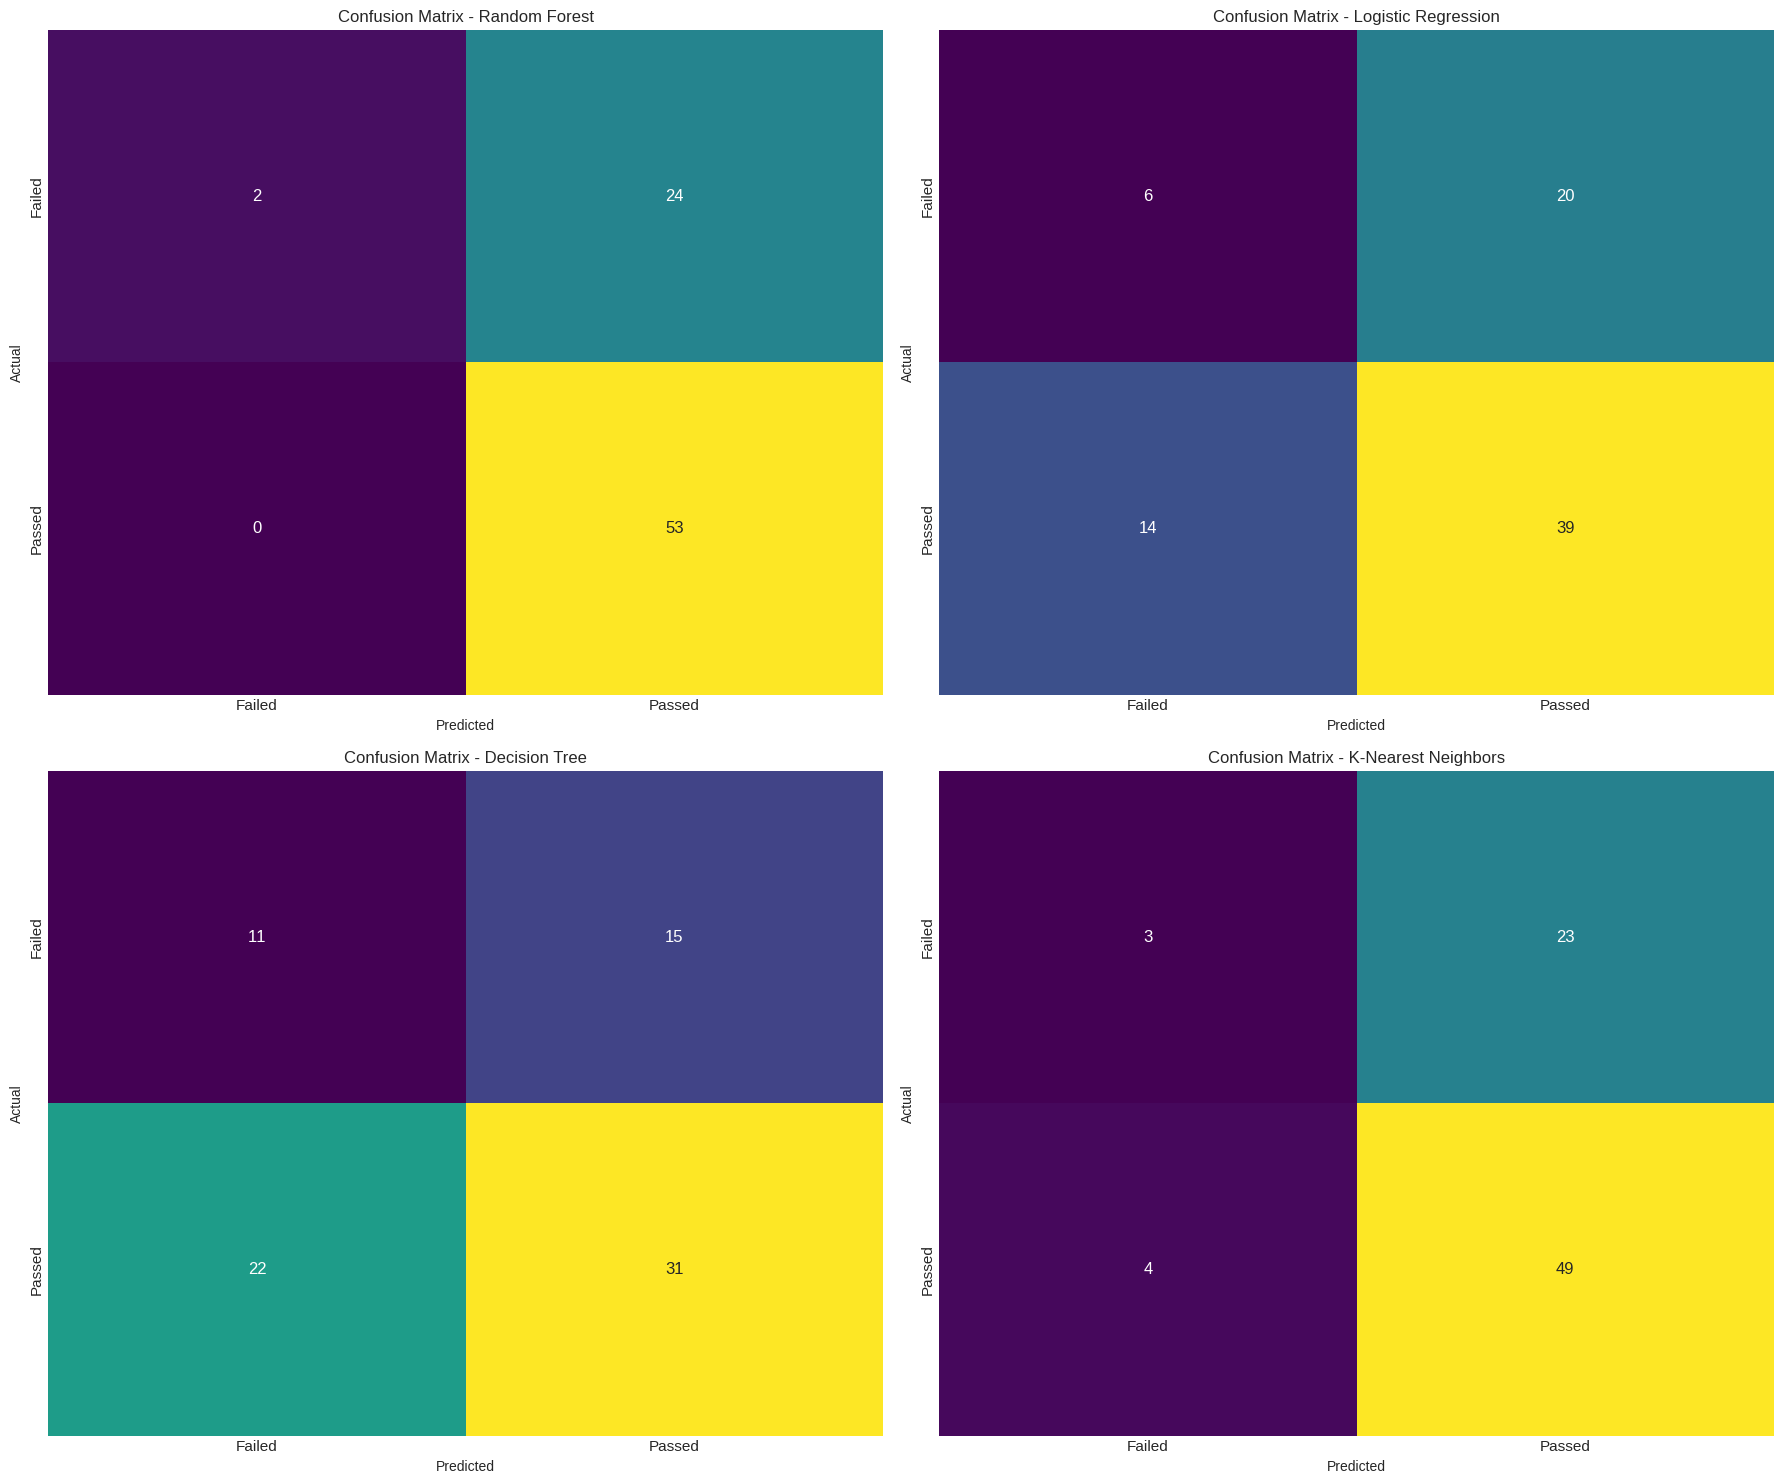

In [114]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, models_dict, ncols=2, figsize=(18, 15)):
    nrows = int(np.ceil(len(models_dict) / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()
    
    for i, model_name in enumerate(models_dict.keys()):
        y_pred = models_dict[model_name]['predictions']
        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=False,
                    xticklabels=['Failed', 'Passed'],
                    yticklabels=['Failed', 'Passed'],
                    ax=axes[i])
            
        axes[i].set_title(f'Confusion Matrix - {model_name}', fontsize=12)
        axes[i].set_xlabel('Predicted', fontsize=10)
        axes[i].set_ylabel('Actual', fontsize=10)
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test, baseline_results)

### 4.3 ROC Curves
**ROC AUC** (Receiver Operating Characteristic - Area Under Curve) is a performance metric used to evaluate binary classification models. It represents how well the model separates the positive and negative cases.


>The higher the curve, the closer to 1 the AUC is, therefore, the better the model is at making correct predictions.

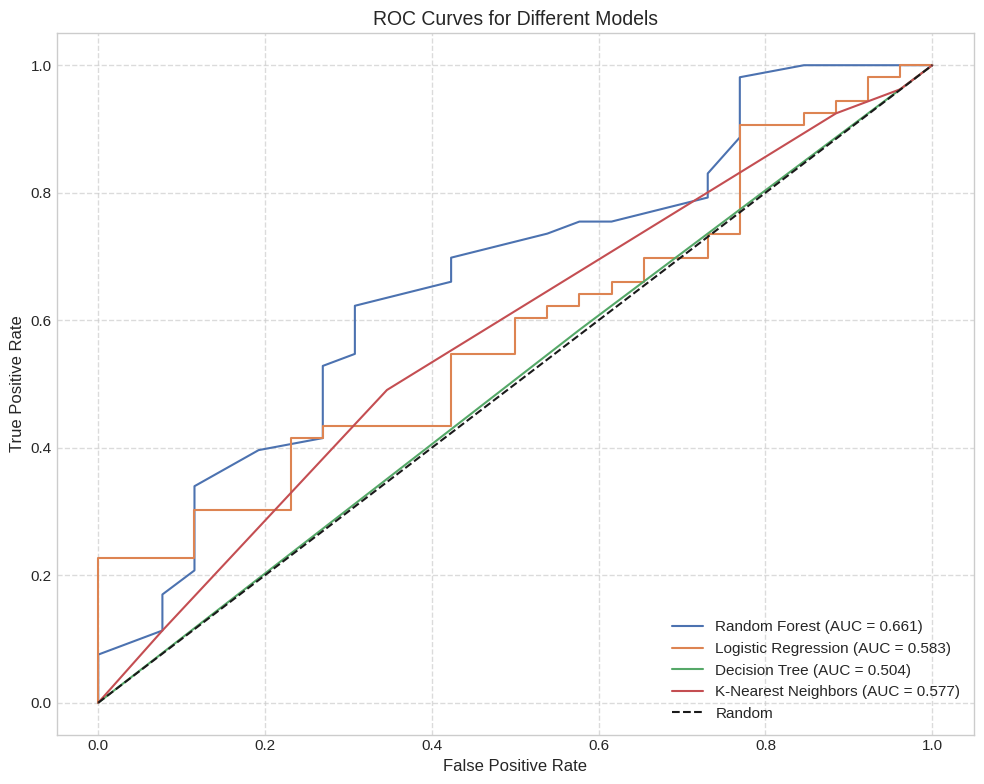

In [115]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

for model_name in baseline_models.keys():
    if baseline_results[model_name]['probabilities'] is not None:
        fpr, tpr, _ = roc_curve(y_test, baseline_results[model_name]['probabilities'])
        auc_score = baseline_results[model_name]['roc_auc']
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for Different Models', fontsize=14)
plt.legend(loc='lower right')
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 5. Handling Imbalance

Introduce `class_weight` and/or SMOTE to handle the `passed` class imbalance.

**Class weighting** assigns different weights to different classes in a data set during model training

**SMOTE** (Synthetic Minority Over-Sampling Technique) generates new synthetic samples for the minority class by interpolating between existing minority class instances.

## 5.1 Class Weighting Only

In [116]:
weighted_models = {
    'Random Forest (Weighted)': RandomForestClassifier(
        class_weight={0: 2, 1: 1},
        random_state=42
    ),
    'Logistic Regression (Weighted)': LogisticRegression(
        class_weight={0: 2, 1: 1},
        random_state=42
    ),
    'Decision Tree (Weighted)': DecisionTreeClassifier(
        class_weight={0: 2, 1: 1},
        random_state=42
    )
}

In [117]:
# Evaluate all weighted models
weighted_results = {}
for name, model in weighted_models.items():
    print(f"Training {name}...")
    weighted_results[name] = evaluate_model(model, X_train_processed, X_test_processed, y_train, y_test)
    print(f"""{name}:
    - Accuracy: {weighted_results[name]['accuracy']:.4f}
    - Failed Recall: {weighted_results[name]['failed_recall']:.4f}
    - Failed Precision: {weighted_results[name]['failed_precision']:.4f}
    - Failed F1: {weighted_results[name]['failed_f1']:.4f}
    - Pass Recall: {weighted_results[name]['pass_recall']:.4f}
    - Pass Precision: {weighted_results[name]['pass_precision']:.4f}
    - Pass F1: {weighted_results[name]['pass_f1']:.4f}
    - ROC AUC: {weighted_results[name]['roc_auc']:.4f}
    """)

Training Random Forest (Weighted)...
Random Forest (Weighted):
    - Accuracy: 0.6582
    - Failed Recall: 0.0769
    - Failed Precision: 0.4000
    - Failed F1: 0.1290
    - Pass Recall: 0.9434
    - Pass Precision: 0.6757
    - Pass F1: 0.7874
    - ROC AUC: 0.6600
    
Training Logistic Regression (Weighted)...
Logistic Regression (Weighted):
    - Accuracy: 0.5443
    - Failed Recall: 0.5385
    - Failed Precision: 0.3684
    - Failed F1: 0.4375
    - Pass Recall: 0.5472
    - Pass Precision: 0.7073
    - Pass F1: 0.6170
    - ROC AUC: 0.5798
    
Training Decision Tree (Weighted)...
Decision Tree (Weighted):
    - Accuracy: 0.6076
    - Failed Recall: 0.4231
    - Failed Precision: 0.4074
    - Failed F1: 0.4151
    - Pass Recall: 0.6981
    - Pass Precision: 0.7115
    - Pass F1: 0.7048
    - ROC AUC: 0.5606
    


In [118]:
# Create a comparison table of weighted model performance
weighted_model_comparison = pd.DataFrame({
    'Model': [model for model in weighted_results.keys()],
    'Accuracy': [weighted_results[model]['accuracy'] for model in weighted_results],
    'Failed Precision': [weighted_results[model]['failed_precision'] for model in weighted_results],
    'Failed Recall': [weighted_results[model]['failed_recall'] for model in weighted_results],
    'Failed F1 Score': [weighted_results[model]['failed_f1'] for model in weighted_results],
    'Pass Precision': [weighted_results[model]['pass_precision'] for model in weighted_results],
    'Pass Recall': [weighted_results[model]['pass_recall'] for model in weighted_results],
    'Pass F1 Score': [weighted_results[model]['pass_f1'] for model in weighted_results],
    'ROC AUC': [weighted_results[model]['roc_auc'] for model in weighted_results]
})

# Sort by Failed F1 score
weighted_model_comparison = weighted_model_comparison.sort_values('Failed F1 Score', ascending=False).reset_index(drop=True)
weighted_model_comparison

,Model,Accuracy,Failed Precision,Failed Recall,Failed F1 Score,Pass Precision,Pass Recall,Pass F1 Score,ROC AUC
0,Logistic Regression (Weighted),0.544304,0.368421,0.538462,0.437500,0.707317,0.547170,0.617021,0.579826
1,Decision Tree (Weighted),0.607595,0.407407,0.423077,0.415094,0.711538,0.698113,0.704762,0.560595
2,Random Forest (Weighted),0.658228,0.400000,0.076923,0.129032,0.675676,0.943396,0.787402,0.660015


In [119]:
baseline_model_comparison

,Model,Accuracy,Failed Precision,Failed Recall,Failed F1 Score,Pass Precision,Pass Recall,Pass F1 Score,ROC AUC
0,Decision Tree,0.531646,0.333333,0.423077,0.372881,0.673913,0.584906,0.626263,0.503991
1,Logistic Regression,0.569620,0.300000,0.230769,0.260870,0.661017,0.735849,0.696429,0.582729
2,K-Nearest Neighbors,0.658228,0.428571,0.115385,0.181818,0.680556,0.924528,0.784000,0.576923
3,Random Forest,0.696203,1.000000,0.076923,0.142857,0.688312,1.000000,0.815385,0.661466


## 5.2 Class Weighting + SMOTE

In [120]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

smote_models = {
    'Random Forest (Weighted + SMOTE)': Pipeline([
        ('smote', SMOTE(sampling_strategy={0: 200}, random_state=42)),
        ('model', RandomForestClassifier(class_weight={0: 2, 1: 1}, random_state=42))
    ]),
    'Logistic Regression (Weighted + SMOTE)': Pipeline([
        ('smote', SMOTE(sampling_strategy={0: 200}, random_state=42)),
        ('model', LogisticRegression(class_weight={0: 2, 1: 1}, random_state=42))
    ]),
    'Decision Tree (Weighted + SMOTE)': Pipeline([
        ('smote', SMOTE(sampling_strategy={0: 200}, random_state=42)),
        ('model', DecisionTreeClassifier(class_weight={0: 2, 1: 1}, random_state=42))
    ]),
    'K-Nearest Neighbors (SMOTE)': Pipeline([
        ('smote', SMOTE(sampling_strategy={0: 200}, random_state=42)),
        ('model', KNeighborsClassifier())
    ])
}

In [121]:
# Evaluate all (weighted + SMOTE) models
smote_results = {}
for name, model in smote_models.items():
    print(f"Training {name}...")
    smote_results[name] = evaluate_model(model, X_train_processed, X_test_processed, y_train, y_test)
    print(f"""{name}:
    - Accuracy: {smote_results[name]['accuracy']:.4f}
    - Failed Recall: {smote_results[name]['failed_recall']:.4f}
    - Failed Precision: {smote_results[name]['failed_precision']:.4f}
    - Failed F1: {smote_results[name]['failed_f1']:.4f}
    - Pass Recall: {smote_results[name]['pass_recall']:.4f}
    - Pass Precision: {smote_results[name]['pass_precision']:.4f}
    - Pass F1: {smote_results[name]['pass_f1']:.4f}
    - ROC AUC: {smote_results[name]['roc_auc']:.4f}
    """)

Training Random Forest (Weighted + SMOTE)...
Random Forest (Weighted + SMOTE):
    - Accuracy: 0.6962
    - Failed Recall: 0.1923
    - Failed Precision: 0.6250
    - Failed F1: 0.2941
    - Pass Recall: 0.9434
    - Pass Precision: 0.7042
    - Pass F1: 0.8065
    - ROC AUC: 0.5980
    
Training Logistic Regression (Weighted + SMOTE)...
Logistic Regression (Weighted + SMOTE):
    - Accuracy: 0.4684
    - Failed Recall: 0.6923
    - Failed Precision: 0.3462
    - Failed F1: 0.4615
    - Pass Recall: 0.3585
    - Pass Precision: 0.7037
    - Pass F1: 0.4750
    - ROC AUC: 0.5842
    
Training Decision Tree (Weighted + SMOTE)...
Decision Tree (Weighted + SMOTE):
    - Accuracy: 0.6456
    - Failed Recall: 0.4615
    - Failed Precision: 0.4615
    - Failed F1: 0.4615
    - Pass Recall: 0.7358
    - Pass Precision: 0.7358
    - Pass F1: 0.7358
    - ROC AUC: 0.5987
    
Training K-Nearest Neighbors (SMOTE)...
K-Nearest Neighbors (SMOTE):
    - Accuracy: 0.5316
    - Failed Recall: 0.8462
 

In [122]:
# Create a comparison table of smote model performance
smote_model_comparison = pd.DataFrame({
    'Model': [model for model in smote_results.keys()],
    'Accuracy': [smote_results[model]['accuracy'] for model in smote_results],
    'Failed Precision': [smote_results[model]['failed_precision'] for model in smote_results],
    'Failed Recall': [smote_results[model]['failed_recall'] for model in smote_results],
    'Failed F1 Score': [smote_results[model]['failed_f1'] for model in smote_results],
    'Pass Precision': [smote_results[model]['pass_precision'] for model in smote_results],
    'Pass Recall': [smote_results[model]['pass_recall'] for model in smote_results],
    'Pass F1 Score': [smote_results[model]['pass_f1'] for model in smote_results],
    'ROC AUC': [smote_results[model]['roc_auc'] for model in smote_results]
})

# Sort by Failed F1 score
smote_model_comparison = smote_model_comparison.sort_values('Failed F1 Score', ascending=False).reset_index(drop=True)
smote_model_comparison

,Model,Accuracy,Failed Precision,Failed Recall,Failed F1 Score,Pass Precision,Pass Recall,Pass F1 Score,ROC AUC
0,K-Nearest Neighbors (SMOTE),0.531646,0.400000,0.846154,0.543210,0.833333,0.377358,0.519481,0.693033
1,Logistic Regression (Weighted + SMOTE),0.468354,0.346154,0.692308,0.461538,0.703704,0.358491,0.475000,0.584180
2,Decision Tree (Weighted + SMOTE),0.645570,0.461538,0.461538,0.461538,0.735849,0.735849,0.735849,0.598694
3,Random Forest (Weighted + SMOTE),0.696203,0.625000,0.192308,0.294118,0.704225,0.943396,0.806452,0.597968


In [123]:
weighted_model_comparison

,Model,Accuracy,Failed Precision,Failed Recall,Failed F1 Score,Pass Precision,Pass Recall,Pass F1 Score,ROC AUC
0,Logistic Regression (Weighted),0.544304,0.368421,0.538462,0.437500,0.707317,0.547170,0.617021,0.579826
1,Decision Tree (Weighted),0.607595,0.407407,0.423077,0.415094,0.711538,0.698113,0.704762,0.560595
2,Random Forest (Weighted),0.658228,0.400000,0.076923,0.129032,0.675676,0.943396,0.787402,0.660015


In [124]:
baseline_model_comparison

,Model,Accuracy,Failed Precision,Failed Recall,Failed F1 Score,Pass Precision,Pass Recall,Pass F1 Score,ROC AUC
0,Decision Tree,0.531646,0.333333,0.423077,0.372881,0.673913,0.584906,0.626263,0.503991
1,Logistic Regression,0.569620,0.300000,0.230769,0.260870,0.661017,0.735849,0.696429,0.582729
2,K-Nearest Neighbors,0.658228,0.428571,0.115385,0.181818,0.680556,0.924528,0.784000,0.576923
3,Random Forest,0.696203,1.000000,0.076923,0.142857,0.688312,1.000000,0.815385,0.661466


**Results: Accuracy vs. F1 Tradeoff:**


- Baseline Model: 70% accuracy, but F1 (Failed) = 0.40 → Poor at detecting at-risk students
- Weighted Model: Accuracy dropped to 60%, but F1 (Failed) = 0.50 → More failures caught
- SMOTE Model: Accuracy=60%, F1 (Failed) = 0.60 → Not yet optimal for intervention goals, but getting there.


Although the accuracy dropped using the Weighted and the SMOTE Models, the F1 metric increases, meaning that more at-risk students are flagged.


>It's better to compromise accuracy (and, for example, do an unnecessary intervention) than to risk missing a failing student.

## 6. Hyperparameter Tuning

**Hyperparameter tuning** is the process of finding the best combination of hyperparameters for a model, in order to optimize its performance. We were able to do that with `GridSearchCV`.

Let's optimize the models through hyperparameter tuning.

In [125]:
# Define hyperparameter grids for each model
pipelines = {
    'Random Forest': Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', RandomForestClassifier(random_state=42))
    ]),
    'Logistic Regression': Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', LogisticRegression(random_state=42))
    ]),
    'Decision Tree': Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', DecisionTreeClassifier(random_state=42))
    ]),
    'K-Nearest Neighbors': Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', KNeighborsClassifier())
    ])
}

param_grids = {
    'Random Forest': {
        'smote__sampling_strategy': [{0: 180}, {0: 200}, {0: 220}],
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5, 7],
        'model__min_samples_split': [2, 5],
        'model__class_weight': ['balanced', {0: 2, 1: 1}, {0: 4, 1: 1}, {0: 6, 1: 1}]
    },
    'Logistic Regression': {
        'smote__sampling_strategy': [{0: 150}, {0: 200}],
        'model__C': [1, 0.1, 0.01, 0.001],
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['liblinear'],
        'model__class_weight': [None, {0: 2, 1: 1}]
    },
    'Decision Tree': {
        'smote__sampling_strategy': [{0: 200}],
        'model__max_depth': [3],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 5, 10],
        'model__criterion': ['gini', 'entropy'],
        'model__class_weight': ['balanced', {0: 2, 1: 1}, {0: 3, 1: 1}]
    },
    'K-Nearest Neighbors': {
        'smote__sampling_strategy': [{0: 200}, {0: 250}],
        'model__n_neighbors': [3, 5, 7],
        'model__weights': ['distance'],
        'model__p': [1, 2],
    }
}

In [126]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

failed_f1_scorer = make_scorer(f1_score, pos_label=0, zero_division=1)

# Perform grid search for each top model
tuned_models = {}
tuned_results = {}

for model_name in param_grids.keys():
    print(f"\nPerforming hyperparameter tuning for {model_name}...")
    
    # Create grid search
    grid_search = GridSearchCV(
        estimator=pipelines[model_name],
        param_grid=param_grids[model_name],
        cv=5,
        scoring=failed_f1_scorer,
        n_jobs=-1,
        verbose=1
    )
    
    # Fit grid search
    grid_search.fit(X_train_processed, y_train)
    
    # Get best model
    tuned_models[f"{model_name} (SMOTE + Tuned)"] = grid_search.best_estimator_
    
    # Print results
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Evaluate on test set
    tuned_results[f"{model_name} (SMOTE + Tuned)"] = evaluate_model(
        tuned_models[f"{model_name} (SMOTE + Tuned)"], X_train_processed, X_test_processed, y_train, y_test
    )
    
    print(f"""Test set performance:
    - Accuracy: {tuned_results[f'{model_name} (SMOTE + Tuned)']['accuracy']:.4f}
    - Failed Recall: {tuned_results[f'{model_name} (SMOTE + Tuned)']['failed_recall']:.4f}
    - Failed Precision: {tuned_results[f'{model_name} (SMOTE + Tuned)']['failed_precision']:.4f}
    - Failed F1: {tuned_results[f'{model_name} (SMOTE + Tuned)']['failed_f1']:.4f}
    - Pass Recall: {tuned_results[f'{model_name} (SMOTE + Tuned)']['pass_recall']:.4f}
    - Pass Precision: {tuned_results[f'{model_name} (SMOTE + Tuned)']['pass_precision']:.4f}
    - Pass F1: {tuned_results[f'{model_name} (SMOTE + Tuned)']['pass_f1']:.4f}
    - ROC AUC: {tuned_results[f'{model_name} (SMOTE + Tuned)']['roc_auc']:.4f}
    """)


Performing hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters for Random Forest: {'model__class_weight': {0: 4, 1: 1}, 'model__max_depth': 3, 'model__min_samples_split': 2, 'model__n_estimators': 100, 'smote__sampling_strategy': {0: 180}}
Best cross-validation score: 0.4964
Test set performance:
    - Accuracy: 0.3291
    - Failed Recall: 1.0000
    - Failed Precision: 0.3291
    - Failed F1: 0.4952
    - Pass Recall: 0.0000
    - Pass Precision: 0.0000
    - Pass F1: 0.0000
    - ROC AUC: 0.6183
    

Performing hyperparameter tuning for Logistic Regression...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


/home/jorge/anaconda3/envs/eda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best parameters for Logistic Regression: {'model__C': 0.001, 'model__class_weight': None, 'model__penalty': 'l2', 'model__solver': 'liblinear', 'smote__sampling_strategy': {0: 200}}
Best cross-validation score: 0.5037
Test set performance:
    - Accuracy: 0.7342
    - Failed Recall: 0.6538
    - Failed Precision: 0.5862
    - Failed F1: 0.6182
    - Pass Recall: 0.7736
    - Pass Precision: 0.8200
    - Pass F1: 0.7961
    - ROC AUC: 0.7518
    

Performing hyperparameter tuning for Decision Tree...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Decision Tree: {'model__class_weight': {0: 3, 1: 1}, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 10, 'model__min_samples_split': 2, 'smote__sampling_strategy': {0: 200}}
Best cross-validation score: 0.4333
Test set performance:
    - Accuracy: 0.5190
    - Failed Recall: 0.5769
    - Failed Precision: 0.3571
    - Failed F1: 0.4412
    - Pass Recall: 0.4906
    - Pass Precisio

In [127]:
# Update model comparison with tuned models
tuned_models_comparison = pd.DataFrame({
    'Model': [model for model in tuned_models.keys()],
    'Accuracy': [tuned_results[model]["accuracy"] for model in tuned_models.keys()],
    'Failed Precision': [tuned_results[model]["failed_precision"] for model in tuned_models.keys()],
    'Failed Recall': [tuned_results[model]["failed_recall"] for model in tuned_models.keys()],
    'Failed F1 Score': [tuned_results[model]["failed_f1"] for model in tuned_models.keys()],
    'Pass Precision': [tuned_results[model]['pass_precision'] for model in tuned_models.keys()],
    'Pass Recall': [tuned_results[model]['pass_recall'] for model in tuned_models.keys()],
    'Pass F1 Score': [tuned_results[model]['pass_f1'] for model in tuned_models.keys()],
    'ROC AUC': [tuned_results[model]["roc_auc"] for model in tuned_models.keys()]
})

# Combine with original comparison
final_comparison = pd.concat([baseline_model_comparison, weighted_model_comparison, smote_model_comparison, tuned_models_comparison]).sort_values('Failed F1 Score', ascending=False).reset_index(drop=True)
final_comparison

,Model,Accuracy,Failed Precision,Failed Recall,Failed F1 Score,Pass Precision,Pass Recall,Pass F1 Score,ROC AUC
0,Logistic Regression (SMOTE + Tuned),0.734177,0.586207,0.653846,0.618182,0.820000,0.773585,0.796117,0.751814
1,K-Nearest Neighbors (SMOTE),0.531646,0.400000,0.846154,0.543210,0.833333,0.377358,0.519481,0.693033
2,K-Nearest Neighbors (SMOTE + Tuned),0.518987,0.388889,0.807692,0.525000,0.800000,0.377358,0.512821,0.711176
3,Random Forest (SMOTE + Tuned),0.329114,0.329114,1.000000,0.495238,0.000000,0.000000,0.000000,0.618287
4,Logistic Regression (Weighted + SMOTE),0.468354,0.346154,0.692308,0.461538,0.703704,0.358491,0.475000,0.584180
5,Decision Tree (Weighted + SMOTE),0.645570,0.461538,0.461538,0.461538,0.735849,0.735849,0.735849,0.598694
6,Decision Tree (SMOTE + Tuned),0.518987,0.357143,0.576923,0.441176,0.702703,0.490566,0.577778,0.557329
7,Logistic Regression (Weighted),0.544304,0.368421,0.538462,0.437500,0.707317,0.547170,0.617021,0.579826
8,Decision Tree (Weighted),0.607595,0.407407,0.423077,0.415094,0.711538,0.698113,0.704762,0.560595
9,Decision Tree,0.531646,0.333333,0.423077,0.372881,0.673913,0.584906,0.626263,0.503991


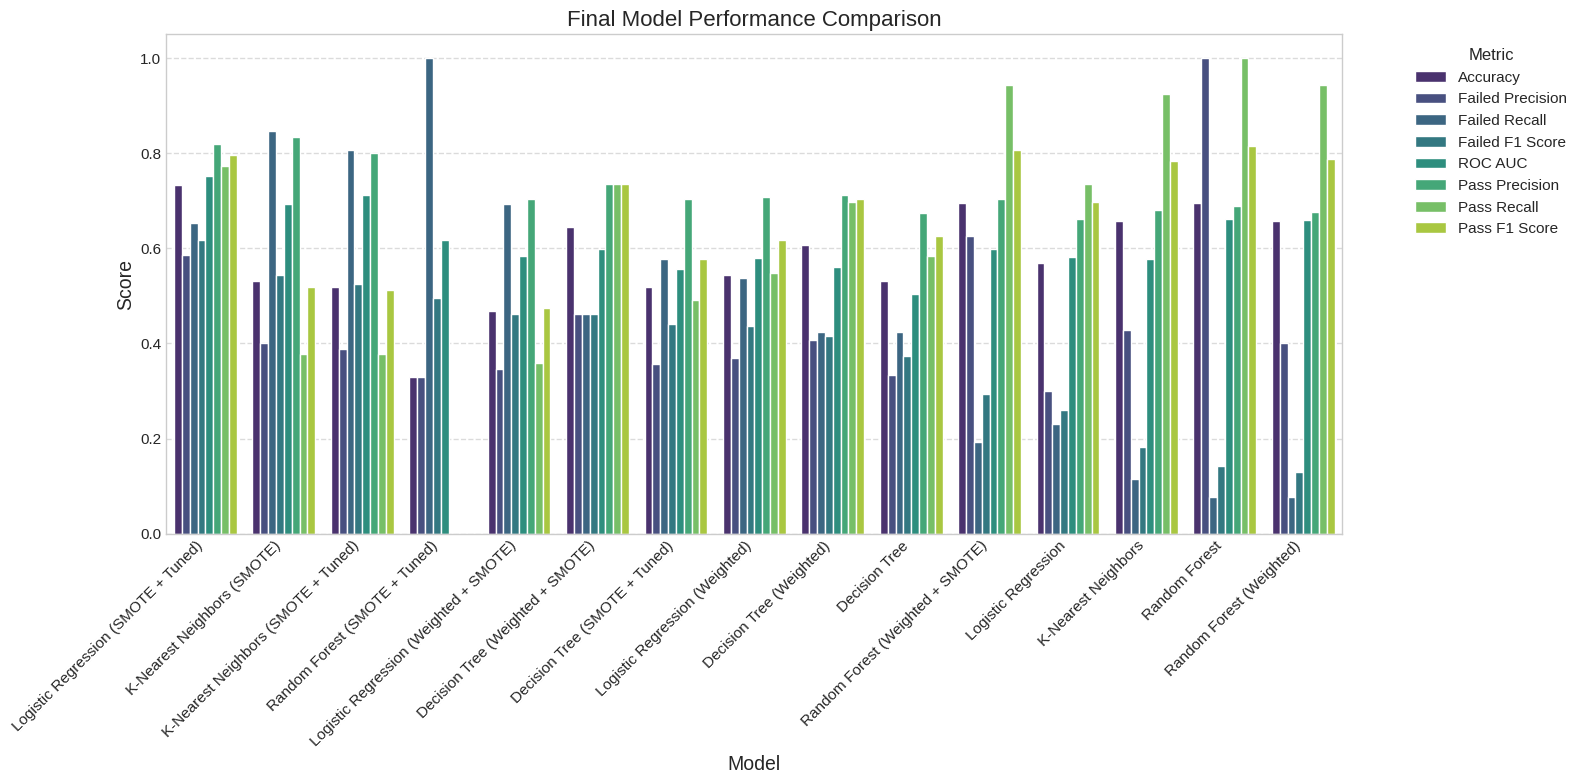

In [128]:
# Visualize final model comparison
plt.figure(figsize=(16, 8))
final_comparison_melted = pd.melt(final_comparison, id_vars=['Model'], value_vars=metrics, var_name='Metric', value_name='Score')

# Highlight tuned models
final_comparison_melted['Model_Type'] = final_comparison_melted['Model'].apply(lambda x: 'Tuned' if '(Tuned)' in x else 'Baseline')

sns.barplot(x='Model', y='Score', hue='Metric', data=final_comparison_melted, palette='viridis')
plt.title('Final Model Performance Comparison', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add markers for tuned models
for i, model in enumerate(final_comparison['Model']):
    if '(Tuned)' in model:
        plt.axvline(x=i, color='red', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [129]:
best_model_name = final_comparison['Model'].iloc[0]
all_models = dict(**baseline_models, **weighted_models, **smote_models, **tuned_models)
all_results = dict(**baseline_results, **weighted_results, **smote_results, **tuned_results)
best_model = all_models[best_model_name]

## 7. Feature Importance Analysis

Let's analyze which features are most important for our best model.

Feature importance not available for Logistic Regression (SMOTE + Tuned)
Feature importance not available for K-Nearest Neighbors (SMOTE)
Feature importance not available for K-Nearest Neighbors (SMOTE + Tuned)
Feature importance not available for Random Forest (SMOTE + Tuned)
Feature importance not available for Logistic Regression (Weighted + SMOTE)
Feature importance not available for Decision Tree (Weighted + SMOTE)
Feature importance not available for Decision Tree (SMOTE + Tuned)
Feature importance not available for Logistic Regression (Weighted)
Top 15 most important features:
                            Feature  Importance
0                     num__absences    0.095723
1                          num__age    0.059386
2               cat__guardian_other    0.055308
3                cat__reason_course    0.050071
4                   cat__health_bad    0.045025
5   num__has_parent_with_higher_edu    0.039402
6                  cat__health_good    0.036438
7                       n

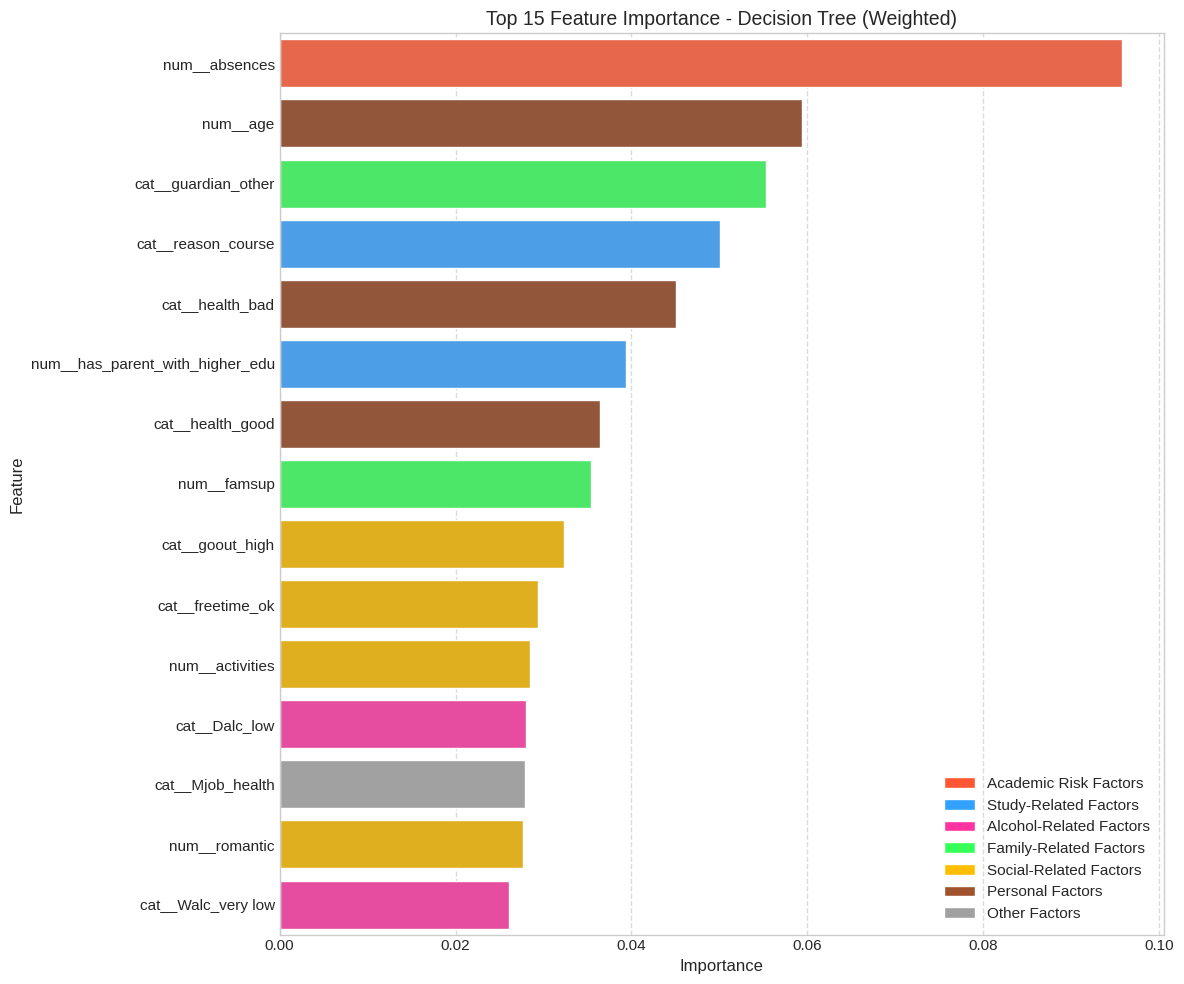

In [130]:
# Function to get feature importance
def get_feature_importance(model, feature_names):
    # For tree-based models
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        return pd.DataFrame({'Feature': feature_names[indices], 'Importance': importances[indices]})
    else:
        return None
    '''
    # For linear models
    elif hasattr(model, 'coef_'):
        coefs = model.coef_[0] if model.coef_.ndim > 1 else model.coef_
        abs_coefs = np.abs(coefs)
        indices = np.argsort(abs_coefs)[::-1]
        return pd.DataFrame({'Feature': feature_names[indices], 'Importance': abs_coefs[indices]})
        '''
    
# Get feature names after preprocessing
feature_names = []
if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = preprocessor.get_feature_names_out()
else:
    # Manual construction of feature names
    num_features = numerical_features
    cat_features = []
    for name, trans, cols in preprocessor.transformers_:
        if name == 'cat' and hasattr(trans.named_steps['onehot'], 'get_feature_names_out'):
            cat_features = trans.named_steps['onehot'].get_feature_names_out(cols)
    feature_names = np.array(num_features + list(cat_features))
    
# Get feature importance for the best model
feature_importance = get_feature_importance(best_model, feature_names)

i = 0
n = len(all_models)
while feature_importance is None and i < n:
    print(f"Feature importance not available for {best_model_name}")
    i += 1
    best_model_name = final_comparison['Model'].iloc[i]
    best_model = all_models[best_model_name]
    feature_importance = get_feature_importance(best_model, feature_names)

if i == n:
    print("Couldn't find a model with feature importance available")
else:
    # Display top 15 features
    print("Top 15 most important features:")
    print(feature_importance.head(15))
    
    # Plot feature importance
    plt.figure(figsize=(12, 10))
    
    # Create a color map based on feature categories
    colors = []
    for feature in feature_importance.head(15)['Feature']:
        if 'risk' in feature or 'absences' in feature or 'failures' in feature:
            colors.append('#FF5733')  # Red for academic risk factors
        elif 'course' in feature or 'study' in feature or 'higher' in feature:
            colors.append('#33A1FF')  # Blue for study-related factors
        elif 'alcohol' in feature or 'Dalc' in feature or 'Walc' in feature:
            colors.append('#FF33A1')  # Pink for alcohol-related factors
        elif 'guardian' in feature or 'fam' in feature or 'parent' in feature or 'family' in feature or 'Medu' in feature or 'Fedu' in feature:
            colors.append('#33FF57')  # Green for family-related factors
        elif 'freetime' in feature or 'romantic' in feature or 'activities' in feature or 'goout' in feature:
            colors.append('#FFBF00')  # Yellow for social-related factors
        elif 'health_' in feature or 'age' in feature:
            colors.append('#A0522D')  # Brown for personal factors
        else:
            colors.append('#A1A1A1')  # Gray for other factors
    
    # Plot with custom colors
    ax = sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15), hue='Feature', palette=colors)
    
    # Add a legend for color categories
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#FF5733', label='Academic Risk Factors'),
        Patch(facecolor='#33A1FF', label='Study-Related Factors'),
        Patch(facecolor='#FF33A1', label='Alcohol-Related Factors'),
        Patch(facecolor='#33FF57', label='Family-Related Factors'),
        Patch(facecolor='#FFBF00', label='Social-Related Factors'),
        Patch(facecolor='#A0522D', label='Personal Factors'),
        Patch(facecolor='#A1A1A1', label='Other Factors')
    ]
    ax.legend(handles=legend_elements, loc='lower right')
    
    plt.title(f'Top 15 Feature Importance - {best_model_name}', fontsize=14)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## 8. Final Model Evaluation

Let's perform a detailed evaluation of our best model.

Best model: Logistic Regression (SMOTE + Tuned)

Classification Report:
              precision    recall  f1-score   support

      Failed       0.59      0.65      0.62        26
      Passed       0.82      0.77      0.80        53

    accuracy                           0.73        79
   macro avg       0.70      0.71      0.71        79
weighted avg       0.74      0.73      0.74        79


Confusion Matrix:
[[17  9]
 [12 41]]


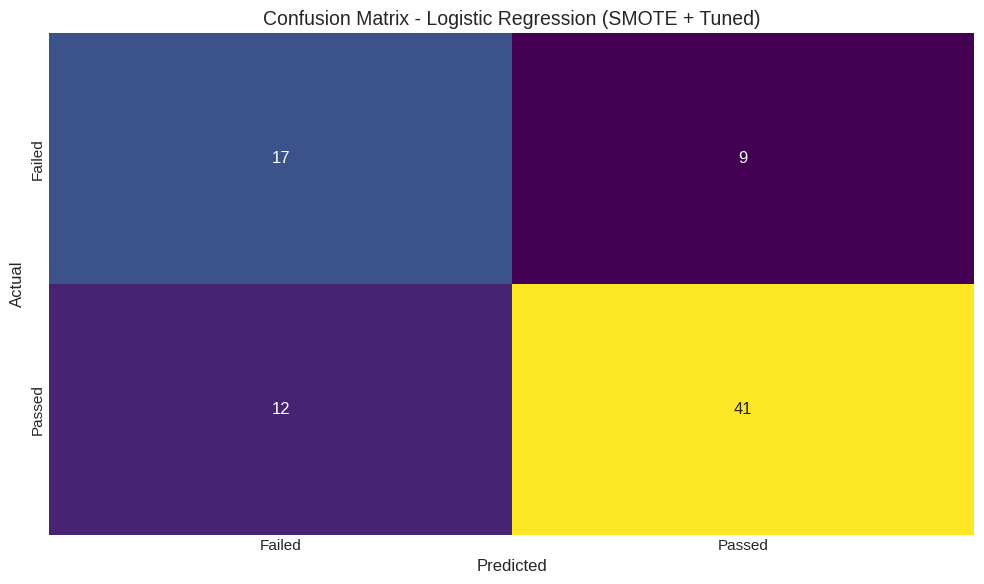

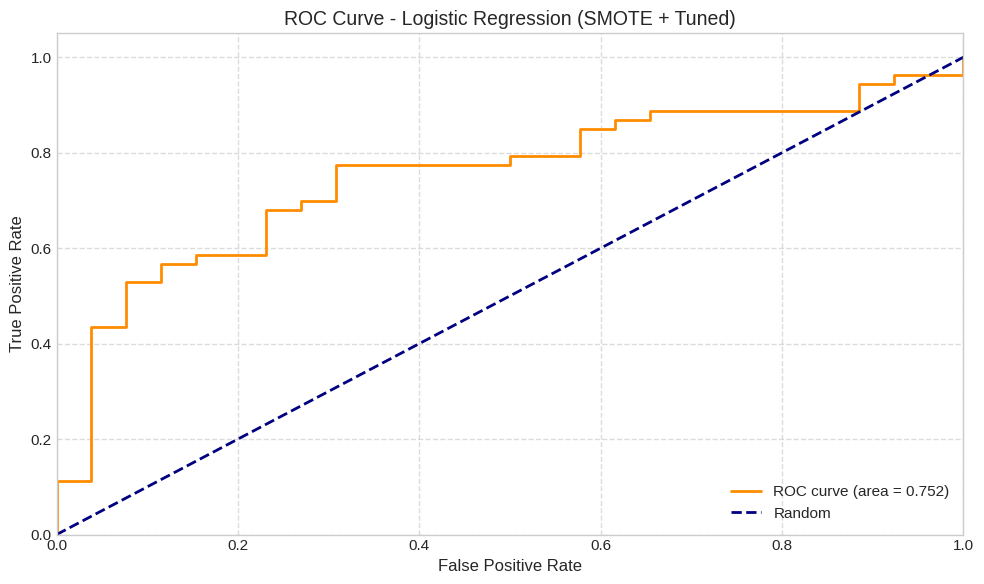

In [131]:
# Get the best model
best_model_name = final_comparison['Model'].iloc[0]
print(f"Best model: {best_model_name}")

# Get predictions and probabilities
y_pred = all_results[best_model_name]['predictions']
y_prob = all_results[best_model_name]['probabilities']

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Failed', 'Passed']))

# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=False,
            xticklabels=['Failed', 'Passed'],
            yticklabels=['Failed', 'Passed'])
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curve - {best_model_name}', fontsize=14)
plt.legend(loc="lower right")
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 8.1 Precision-Recall Curve

A **PR Curve** is a graphical representation of a classifier's performance, plotting precision against recall for different thresholds.

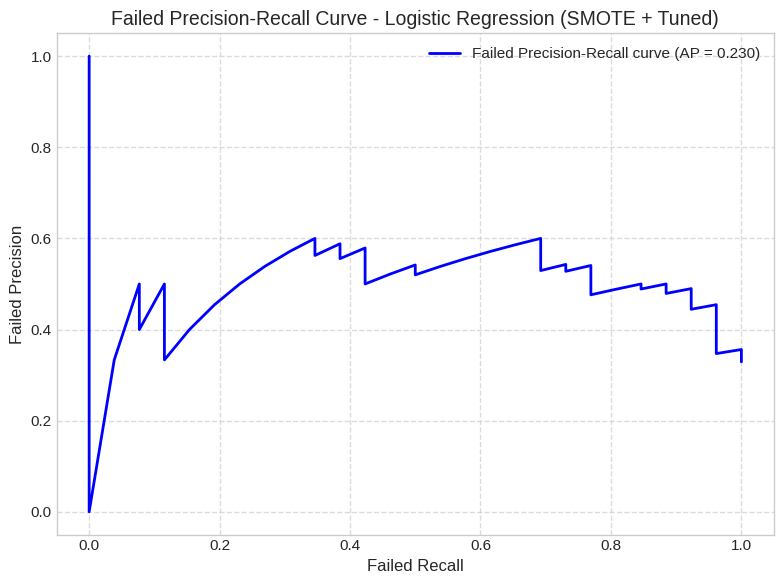

In [132]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate precision-recall curve
failed_precision, failed_recall, _ = precision_recall_curve(y_test, 1-y_prob, pos_label=0)
average_failed_precision = average_precision_score(y_test, y_prob, pos_label=0)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(failed_recall, failed_precision, color='blue', lw=2, label=f'Failed Precision-Recall curve (AP = {average_failed_precision:.3f})')
plt.xlabel('Failed Recall', fontsize=12)
plt.ylabel('Failed Precision', fontsize=12)
plt.title(f'Failed Precision-Recall Curve - {best_model_name}', fontsize=14)
plt.legend(loc="best")
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 8.2 Threshold Analysis

**Threshold Analysis** is a form of sensitivity analysis that investigates how much a parameter would need to change to alter a specific outcome.

Let's analyze how different probability thresholds affect our model's performance.

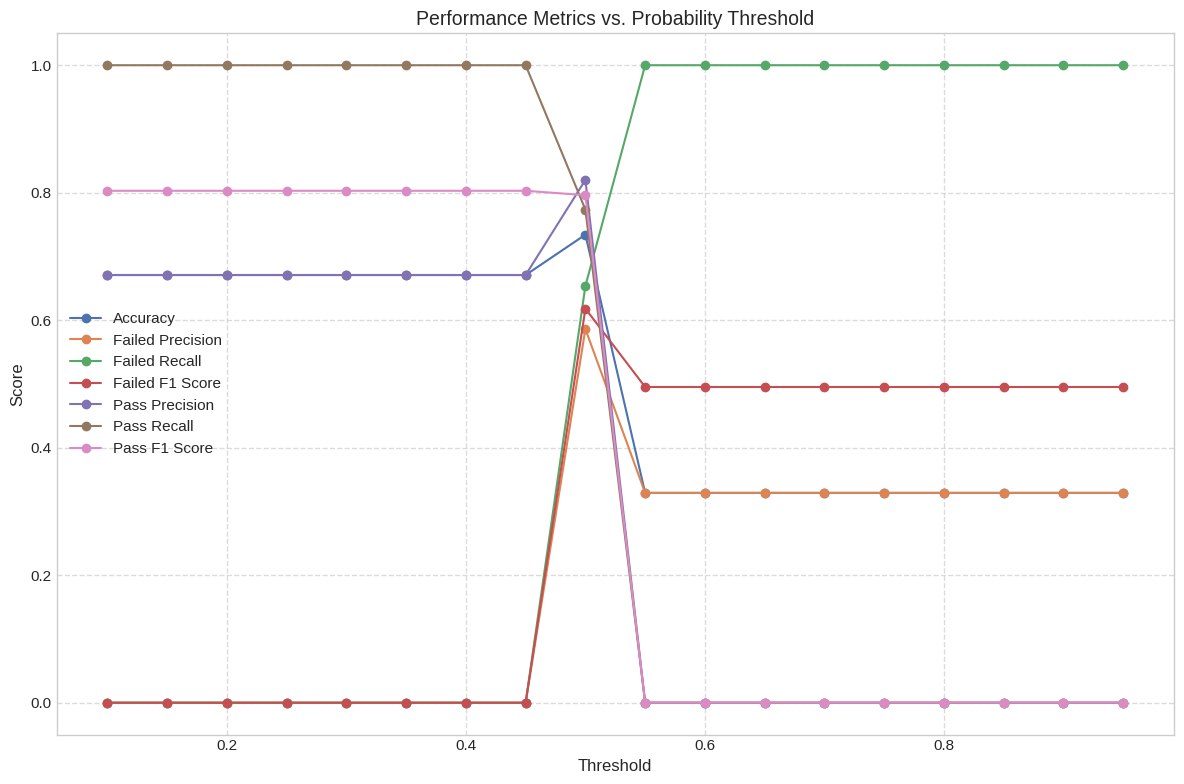

In [133]:
# Calculate metrics at different thresholds
thresholds = np.arange(0.1, 1.0, 0.05)
threshold_metrics = []

for threshold in thresholds:
    y_pred_threshold = (y_prob >= threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_threshold)
    failed_precision = precision_score(y_test, y_pred_threshold, zero_division=0, pos_label=0)
    failed_recall = recall_score(y_test, y_pred_threshold, zero_division=0, pos_label=0)
    failed_f1 = f1_score(y_test, y_pred_threshold, zero_division=0, pos_label=0)
    pass_precision = precision_score(y_test, y_pred_threshold, zero_division=0)
    pass_recall = recall_score(y_test, y_pred_threshold, zero_division=0)
    pass_f1 = f1_score(y_test, y_pred_threshold, zero_division=0)
    
    threshold_metrics.append({
        'Threshold': threshold,
        'Accuracy': accuracy,
        'Failed Precision': failed_precision,
        'Failed Recall': failed_recall,
        'Failed F1 Score': failed_f1,
        'Pass Precision': pass_precision,
        'Pass Recall': pass_recall,
        'Pass F1 Score': pass_f1
    })

threshold_df = pd.DataFrame(threshold_metrics)

# Plot metrics vs threshold
plt.figure(figsize=(12, 8))
plt.plot(threshold_df['Threshold'], threshold_df['Accuracy'], 'o-', label='Accuracy')
plt.plot(threshold_df['Threshold'], threshold_df['Failed Precision'], 'o-', label='Failed Precision')
plt.plot(threshold_df['Threshold'], threshold_df['Failed Recall'], 'o-', label='Failed Recall')
plt.plot(threshold_df['Threshold'], threshold_df['Failed F1 Score'], 'o-', label='Failed F1 Score')
plt.plot(threshold_df['Threshold'], threshold_df['Pass Precision'], 'o-', label='Pass Precision')
plt.plot(threshold_df['Threshold'], threshold_df['Pass Recall'], 'o-', label='Pass Recall')
plt.plot(threshold_df['Threshold'], threshold_df['Pass F1 Score'], 'o-', label='Pass F1 Score')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Performance Metrics vs. Probability Threshold', fontsize=14)
plt.legend(loc='best')
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 9. Student Intervention System

Now let's create a function to identify students who need intervention based on our model.

In [134]:
# Function to predict student outcomes and identify those needing intervention
def predict_student_outcomes(model, preprocessor, student_data, threshold=0.5):
    # Preprocess the data
    X_processed = preprocessor.transform(student_data)
    
    # Get probabilities of passing
    pass_probabilities = model.predict_proba(X_processed)[:, 1]
    
    # Calculate fail probabilities (1 - pass_probabilities)
    fail_probabilities = 1 - pass_probabilities
    
    # Make predictions based on threshold
    # If fail probability >= threshold, predict fail (0)
    predictions = (fail_probabilities >= threshold).astype(int)
    
    # Map predictions back to original labels
    prediction_labels = np.where(predictions == 1, 'no', 'yes')
    
    # Create results DataFrame
    results = student_data.copy()
    results['pass_probability'] = pass_probabilities
    results['fail_probability'] = fail_probabilities
    results['predicted_outcome'] = prediction_labels
    results['needs_intervention'] = (fail_probabilities >= threshold)
    
    # Calculate risk level
    results['risk_level'] = pd.cut(
        fail_probabilities, 
        bins=[0, 0.25, 0.5, 0.75, 1.0], 
        labels=['Very Low Risk', 'Low Risk', 'Moderate Risk', 'High Risk']
    )
    
    return results

# Use the best model to predict outcomes for the test set
best_model_key = best_model_name.replace(' (Tuned)', '') if '(Tuned)' in best_model_name else best_model_name
intervention_results = predict_student_outcomes(
    all_models.get(best_model_name, all_models[best_model_name]),
    preprocessor,
    X_test
)

# Display students needing intervention
students_needing_intervention = intervention_results[intervention_results['needs_intervention']]
print(f"Number of students needing intervention: {len(students_needing_intervention)}")
print(f"Percentage of students needing intervention: {len(students_needing_intervention) / len(intervention_results) * 100:.2f}%")

# Display sample of students needing intervention
print("\nSample of students needing intervention:")
intervention_sample = students_needing_intervention[['school', 'sex', 'age', 'studytime', 'failures', 
                                                   'absences', 'fail_probability', 'risk_level']].head(10)
intervention_sample

Number of students needing intervention: 29
Percentage of students needing intervention: 36.71%

Sample of students needing intervention:


,school,sex,age,studytime,failures,absences,fail_probability,risk_level
225,GP,F,18,2 to 5 hours,1,16,0.513845,Moderate Risk
237,GP,F,16,<2 hours,0,20,0.514902,Moderate Risk
307,GP,M,19,<2 hours,1,38,0.509752,Moderate Risk
255,GP,M,17,<2 hours,1,2,0.510573,Moderate Risk
340,GP,F,19,5 to 10 hours,1,4,0.512610,Moderate Risk
333,GP,F,18,2 to 5 hours,0,0,0.504634,Moderate Risk
370,MS,F,19,2 to 5 hours,2,4,0.511604,Moderate Risk
208,GP,F,16,<2 hours,0,6,0.504276,Moderate Risk
394,MS,M,19,<2 hours,0,5,0.506703,Moderate Risk
332,GP,F,18,2 to 5 hours,0,0,0.502488,Moderate Risk


In [135]:
# Analyze risk factors for students needing intervention
intervention_needed = intervention_results[intervention_results['needs_intervention']]
intervention_not_needed = intervention_results[~intervention_results['needs_intervention']]

# Compare key features between groups
key_features = ['failures', 'absences', 'age']

comparison = pd.DataFrame({
    'Feature': key_features,
    'Intervention Group Mean': intervention_needed[key_features].mean(),
    'Non-Intervention Group Mean': intervention_not_needed[key_features].mean(),
    'Difference': intervention_needed[key_features].mean() - intervention_not_needed[key_features].mean()
})

# Sort by absolute difference
comparison['Abs Difference'] = abs(comparison['Difference'])
comparison = comparison.sort_values('Abs Difference', ascending=False).reset_index(drop=True)
comparison

,Feature,Intervention Group Mean,Non-Intervention Group Mean,Difference,Abs Difference
0,absences,9.137931,4.80,4.337931,4.337931
1,age,17.724138,16.26,1.464138,1.464138
2,failures,0.620690,0.18,0.440690,0.440690


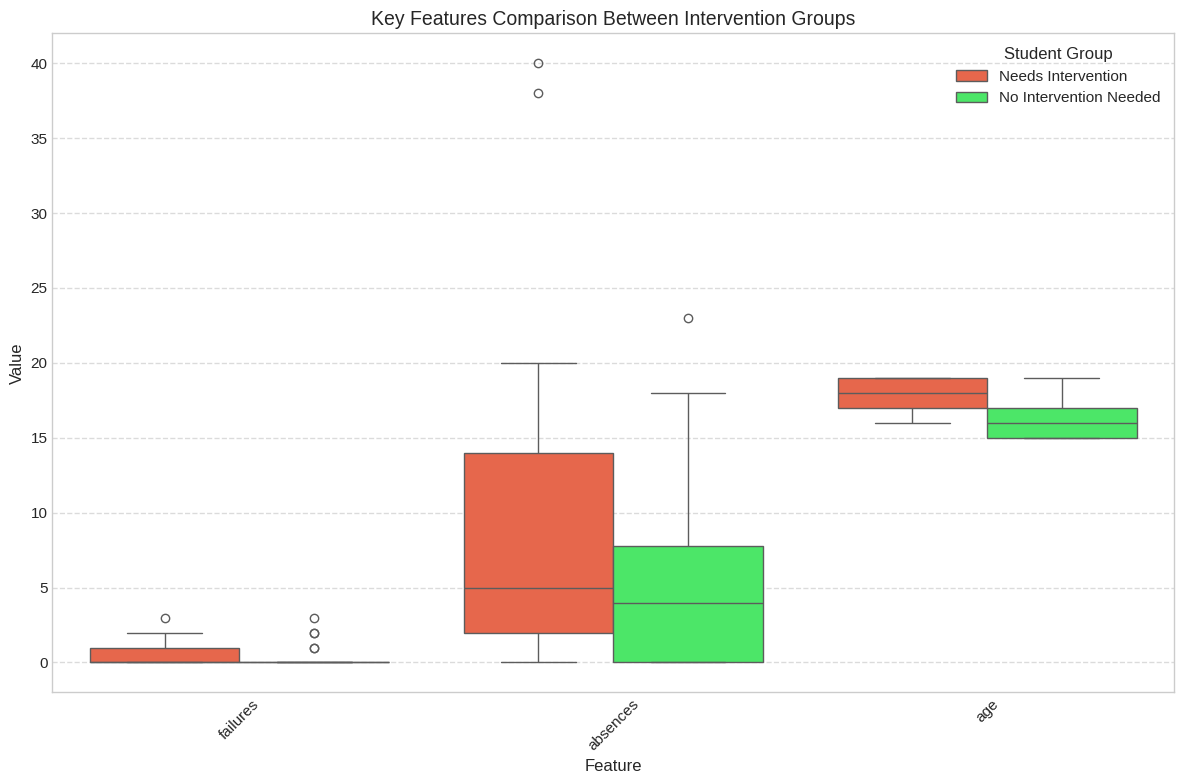

In [136]:
# Visualize key differences
plt.figure(figsize=(12, 8))

# Prepare data for plotting
plot_data = pd.DataFrame()
for feature in key_features:
    plot_data = pd.concat([
        plot_data,
        pd.DataFrame({
            'Feature': feature,
            'Value': intervention_needed[feature],
            'Group': 'Needs Intervention'
        }),
        pd.DataFrame({
            'Feature': feature,
            'Value': intervention_not_needed[feature],
            'Group': 'No Intervention Needed'
        })
    ])

# Create boxplot
sns.boxplot(x='Feature', y='Value', hue='Group', data=plot_data,
            palette={'Needs Intervention': '#FF5733', 'No Intervention Needed': '#33FF57'})
plt.title('Key Features Comparison Between Intervention Groups', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Student Group')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

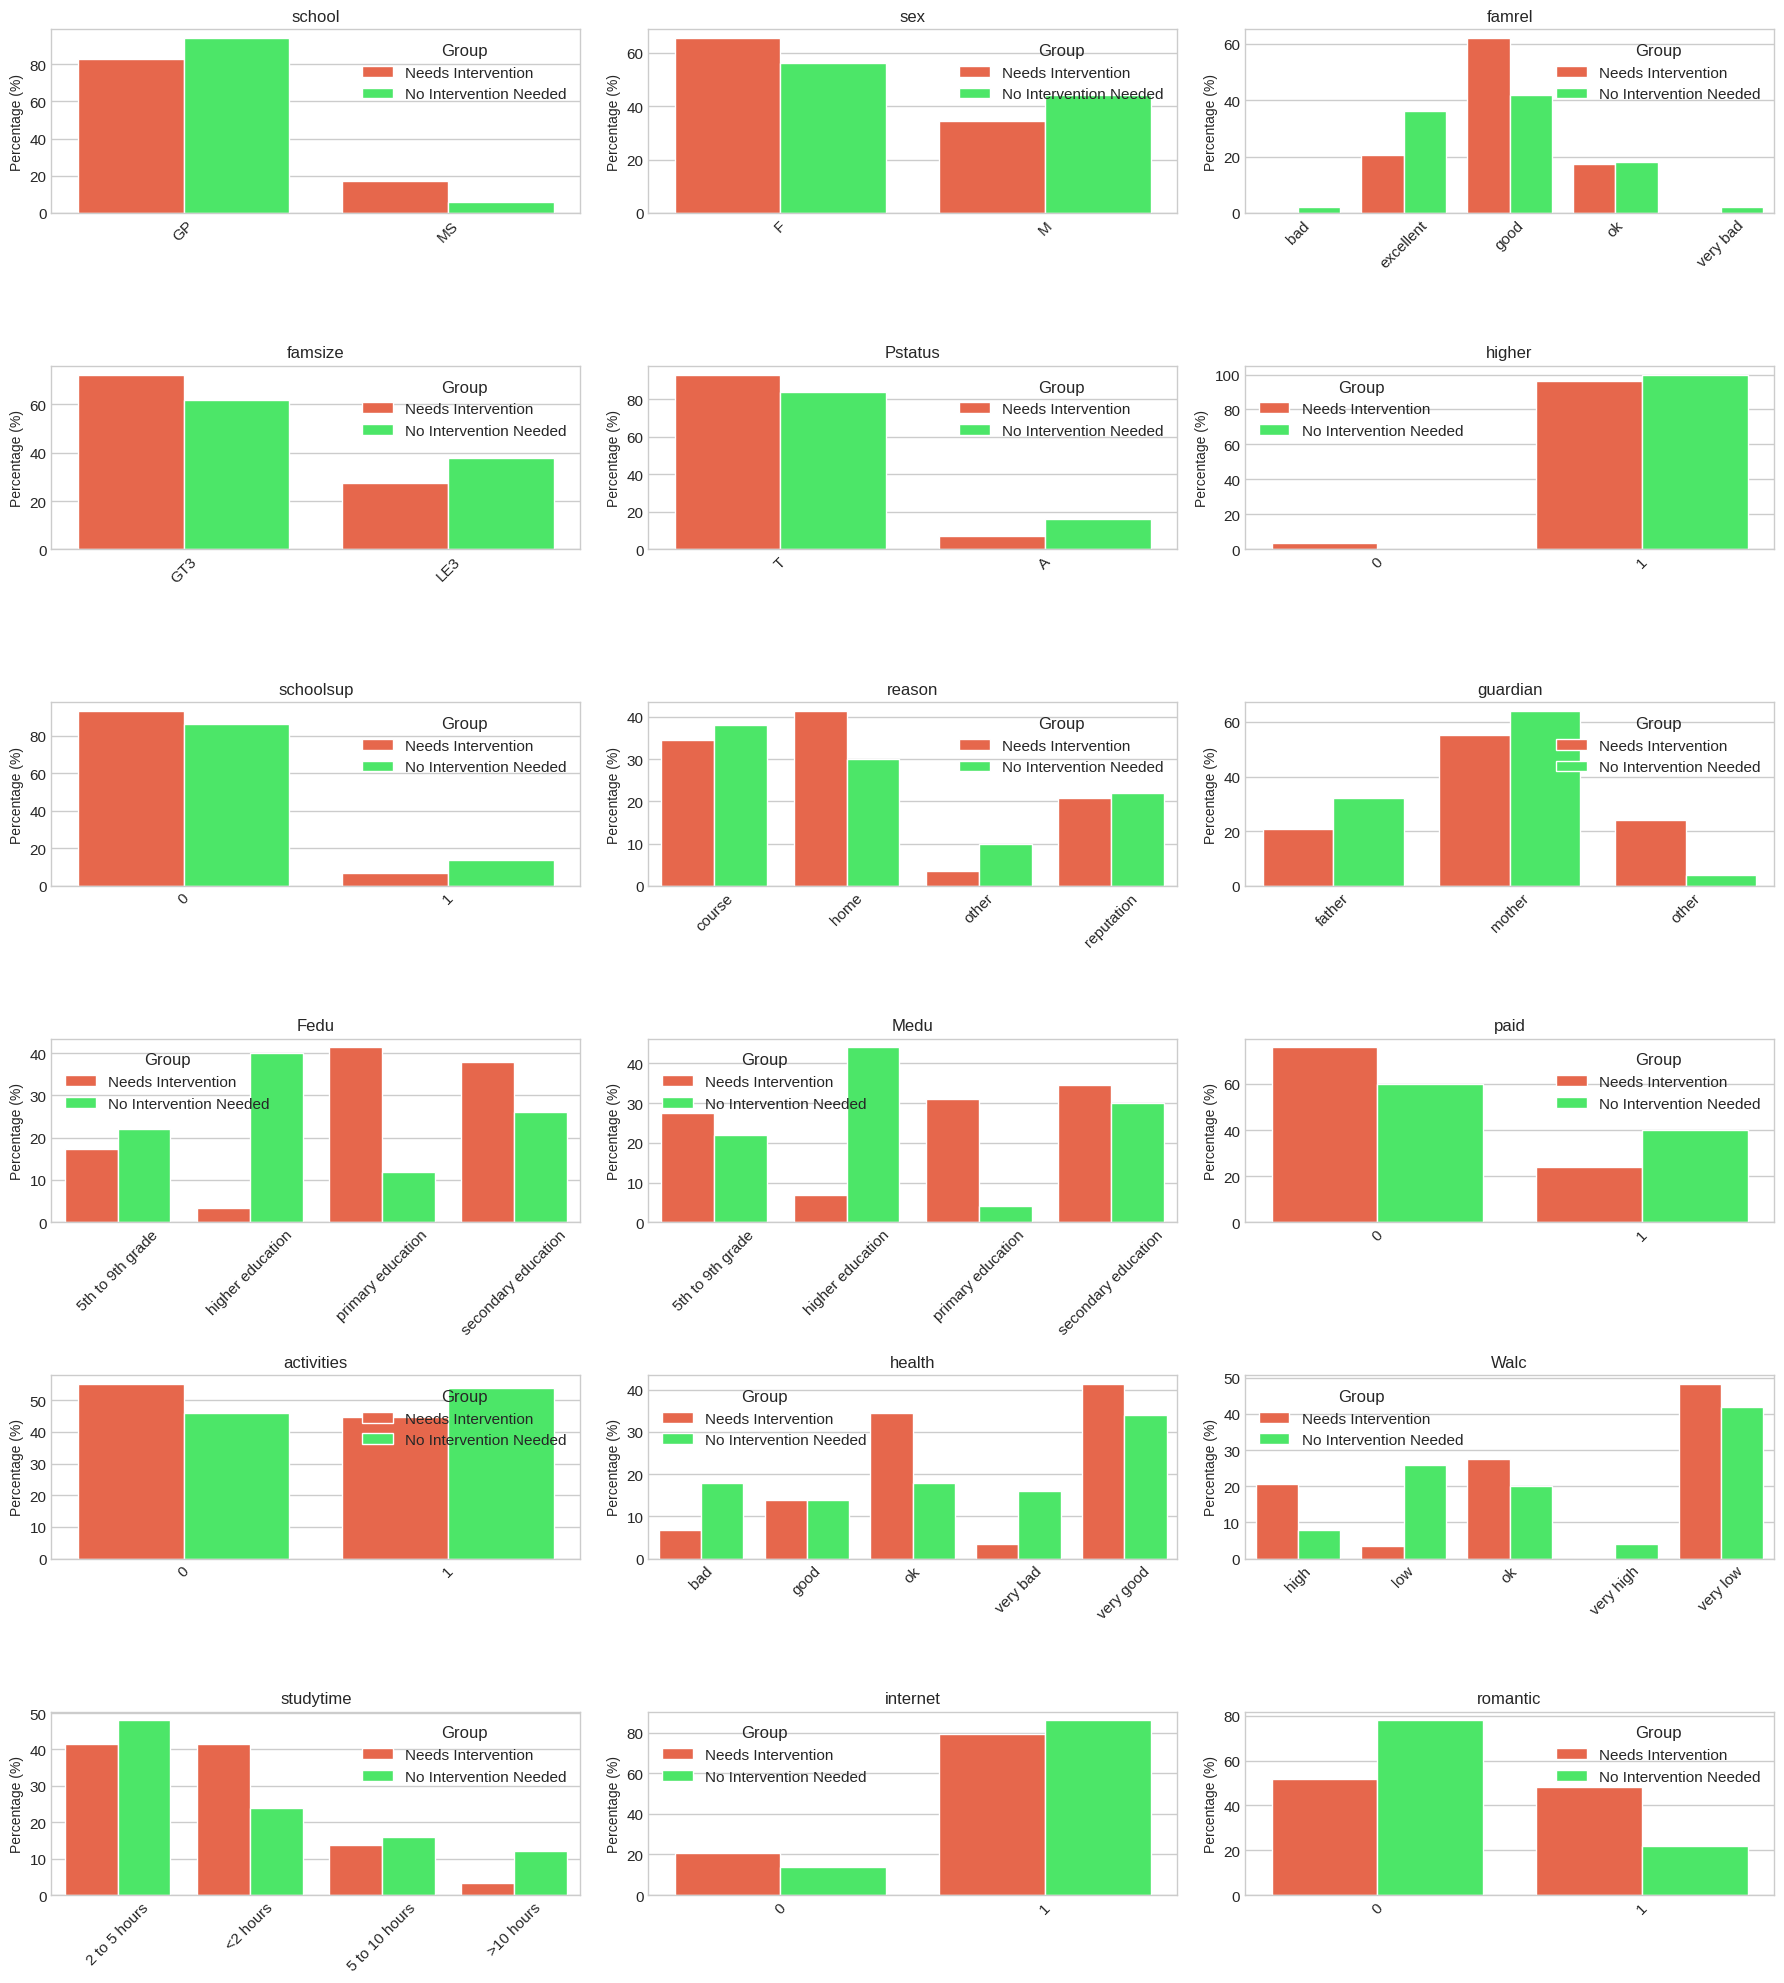

In [137]:
# Analyze categorical features for intervention groups
categorical_risk_factors = ['school', 'sex', 'famrel', 'famsize', 'Pstatus', 'higher', 'schoolsup', 
                           'reason', 'guardian', 'Fedu', 'Medu', 'paid', 'activities', 
                           'health', 'Walc', 'studytime', 'internet', 'romantic']

# Function to calculate and plot categorical feature distributions
def plot_categorical_risk_factors(features, data1, data2, group1_name, group2_name, ncols=3, figsize=(18, 20)):
    nrows = int(np.ceil(len(features) / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()
    
    for i, feature in enumerate(features):
        # Calculate percentages for each group
        counts1 = data1[feature].value_counts(normalize=True) * 100
        counts2 = data2[feature].value_counts(normalize=True) * 100
        
        # Combine into a DataFrame
        df = pd.DataFrame({group1_name: counts1, group2_name: counts2}).fillna(0).reset_index()
        df = pd.melt(df, id_vars=df.columns[0], var_name='Group', value_name='Percentage')
        
        # Plot
        sns.barplot(x=df.columns[0], y='Percentage', hue='Group', data=df, ax=axes[i],
                    palette={'Needs Intervention': '#FF5733', 'No Intervention Needed': '#33FF57'})
        axes[i].set_title(feature, fontsize=12)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Percentage (%)', fontsize=10)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].legend(title='Group')
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Plot categorical risk factors
plot_categorical_risk_factors(
    categorical_risk_factors, 
    intervention_needed, 
    intervention_not_needed, 
    'Needs Intervention', 
    'No Intervention Needed'
)

## 10. Environment Setup

In [142]:
%load_ext watermark
%watermark -iv -v -m

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.11.12
IPython version      : 8.36.0

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 6.1.0-37-amd64
Machine     : x86_64
Processor   : 
CPU cores   : 4
Architecture: 64bit

pandas    : 2.2.3
imblearn  : 0.13.0
sys       : 3.11.12 | packaged by conda-forge | (main, Apr 10 2025, 22:23:25) [GCC 13.3.0]
matplotlib: 3.9.4
seaborn   : 0.13.2
sklearn   : 1.6.1
numpy     : 2.1.3



## 11. Conclusions

Based on our analysis, let's make some important conclusions.

### Key Risk Factors Identified

Our analysis has identified several key factors that are strongly associated with students who need intervention:

1. **Previous failures**: Students with a history of past class failures are at significantly higher risk of failing again.
2. **Absences**: Higher number of absences strongly correlates with academic failure.
3. **Study time**: Students who spend less time studying weekly are more likely to need intervention.
4. **Parent education level**: Lower parental education levels (both mother and father) are risk factors.
5. **Alcohol consumption**: Higher alcohol consumption (especially on weekends) is associated with academic difficulties.
6. **Family relationships**: Poorer family relationships correlate with academic struggles.
7. **Higher education aspirations**: Students without plans for higher education are at greater risk.
8. **School support**: Students without extra educational support from school show higher failure rates.

### Final Thoughts

This project demonstrates the potential of machine learning to support educational decision-making and improve student outcomes. It helped us grasp important concepts surronding the ML & DS realm and it's implementation.